### Import Libraries & Packages

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'


### Load pre-processed data from SQL database

In [2]:
engine = create_engine('mssql+pyodbc://MSI/predictive_maintenance_db?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')
errors_df = pd.read_sql('SELECT * FROM PdM_errors', con=engine)
failures_df = pd.read_sql('SELECT * FROM PdM_failures', con=engine)
machines_df = pd.read_sql('SELECT * FROM PdM_machines', con=engine)
maint_df = pd.read_sql('SELECT * FROM PdM_maint', con=engine)
telemetry_df = pd.read_sql('SELECT * FROM PdM_telemetry', con=engine)

### Read datasets

In [3]:
print("Errors DataFrame:")
display(errors_df.head())

print("Failures DataFrame:")
display(failures_df.head())

print("Machines DataFrame:")
display(machines_df.head())

print("Maintenance DataFrame:")
display(maint_df.head())

print("Telemetry DataFrame:")
display(telemetry_df.head())


Errors DataFrame:


,datetime,machineID,errorID,date
0,2015-01-03 07:00:00,1,error1,2015-01-03
1,2015-01-03 20:00:00,1,error3,2015-01-03
2,2015-01-04 06:00:00,1,error5,2015-01-04
3,2015-01-10 15:00:00,1,error4,2015-01-10
4,2015-01-22 10:00:00,1,error4,2015-01-22


Failures DataFrame:


,datetime,machineID,failure,date
0,2015-01-05 06:00:00,1,comp4,2015-01-05
1,2015-03-06 06:00:00,1,comp1,2015-03-06
2,2015-04-20 06:00:00,1,comp2,2015-04-20
3,2015-06-19 06:00:00,1,comp4,2015-06-19
4,2015-09-02 06:00:00,1,comp4,2015-09-02


Machines DataFrame:


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


Maintenance DataFrame:


,datetime,machineID,comp,date
0,2014-06-01 06:00:00,1,comp2,2014-06-01
1,2014-07-16 06:00:00,1,comp4,2014-07-16
2,2014-07-31 06:00:00,1,comp3,2014-07-31
3,2014-12-13 06:00:00,1,comp1,2014-12-13
4,2015-01-05 06:00:00,1,comp4,2015-01-05


Telemetry DataFrame:


,datetime,machineID,volt,rotate,pressure,vibration,date
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01


In [4]:
print(telemetry_df.head())
print(telemetry_df['datetime'].min(), telemetry_df['datetime'].max())


             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration        date  
0  45.087686  2015-01-01  
1  43.413973  2015-01-01  
2  34.178847  2015-01-01  
3  41.122144  2015-01-01  
4  25.990511  2015-01-01  
2015-01-01 06:00:00 2016-01-01 06:00:00


In [5]:
telemetry_df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,876100,2015-07-02 18:00:00,2015-01-01 06:00:00,2015-04-02 12:00:00,2015-07-02 18:00:00,2015-10-02 00:00:00,2016-01-01 06:00:00,NaN
machineID,876100.0,50.5,1.0,25.75,50.5,75.25,100.0,28.866087
volt,876100.0,170.777736,97.333604,160.304927,170.607338,181.004493,255.124717,15.509114
rotate,876100.0,446.605119,138.432075,412.305714,447.55815,482.1766,695.020984,52.673886
pressure,876100.0,100.858668,51.237106,93.498181,100.425559,107.555231,185.951998,11.048679
vibration,876100.0,40.385007,14.877054,36.777299,40.237247,43.784938,76.791072,5.370361


- Here we see sensor data for 4 operational settings that occurred over 12 months between January 1, 2015, and January 01, 2016. 


In [6]:
print(failures_df.head())
print(failures_df['datetime'].min(), failures_df['datetime'].max())


             datetime  machineID failure        date
0 2015-01-05 06:00:00          1   comp4  2015-01-05
1 2015-03-06 06:00:00          1   comp1  2015-03-06
2 2015-04-20 06:00:00          1   comp2  2015-04-20
3 2015-06-19 06:00:00          1   comp4  2015-06-19
4 2015-09-02 06:00:00          1   comp4  2015-09-02
2015-01-02 03:00:00 2015-12-31 06:00:00


- Here we see that failures occurred over 12 months between January 2, 2015, and December 31, 2015. - 
- Failures involve different components (comp1, comp2, comp4), all related to machine ID 1 during this time range. 

### Here we drill down to focus on one machine from 100, namely machine no. 17

In [7]:
df_sel_17 = telemetry_df.loc[telemetry_df['machineID'] == 17].reset_index(drop=True)
print(df_sel_17.head(n=5))

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00         17  161.633747  462.698035   90.377391   
1 2015-01-01 07:00:00         17  189.976790  372.798586  100.125906   
2 2015-01-01 08:00:00         17  186.476591  498.922070   97.924391   
3 2015-01-01 09:00:00         17  167.836488  483.978488  111.113911   
4 2015-01-01 10:00:00         17  182.431544  502.774702  108.220639   

   vibration        date  
0  49.453414  2015-01-01  
1  57.482661  2015-01-01  
2  47.786767  2015-01-01  
3  66.352721  2015-01-01  
4  54.571089  2015-01-01  


In [8]:
df_sel_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   8761 non-null   datetime64[ns]
 1   machineID  8761 non-null   int64         
 2   volt       8761 non-null   float64       
 3   rotate     8761 non-null   float64       
 4   pressure   8761 non-null   float64       
 5   vibration  8761 non-null   float64       
 6   date       8761 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 479.2+ KB


 - This machine number 17 has 8761 rows and 7 columns, including telemetry data (volt, rotate, pressure, vibration) and machineID.
- All columns are numeric except for the datetime column which is a timestamp, and date which is an object type (string).
- Memory used is approx 479.2 KB 
- There are no missing values.

In [9]:
print(df_sel_17[['volt', 'rotate', 'pressure', 'vibration']].describe())

              volt       rotate     pressure    vibration
count  8761.000000  8761.000000  8761.000000  8761.000000
mean    170.726237   445.968525   101.342908    40.549045
std      15.694063    53.034564    11.325382     5.516199
min     107.286569   223.268150    66.079113    20.487291
25%     160.150078   411.696585    93.976460    36.896442
50%     170.503300   446.855943   100.851812    40.320077
75%     181.075973   482.323013   107.945500    43.925871
max     240.105419   637.852152   152.605505    70.587984


- Sensor Ranges: All sensor readings (voltage, rotation, pressure, vibration) show reasonable variability, with voltage and rotation having the highest range of values.

- Relatively Low Variation in Vibration: The vibration sensor has the lowest standard deviation, meaning its values are more tightly clustered around the mean compared to other sensors

In [10]:
df_sel_17.duplicated().sum()

0

In [11]:
round(df_sel_17.isnull().sum() / df_sel_17.isnull().count() * 100, 2)

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
date         0.0
dtype: float64

- This is just an additional check, but we can confirm here that there are no missing values and that our pre-processing of the raw datasets cleared any duplicates.

In [12]:
def histogram_boxplot(df_sel_17, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True,  
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    sns.boxplot(
        data=df_sel_17, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  
    sns.histplot(
        data=df_sel_17, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df_sel_17, x=feature, kde=kde, ax=ax_hist2
    )  
    ax_hist2.axvline(
        df_sel_17[feature].mean(), color="green", linestyle="--"
    ) 
    ax_hist2.axvline(
        df_sel_17[feature].median(), color="black", linestyle="-"
    )  

Skipping column: datetime
Skipping column: machineID
Skipping column: date


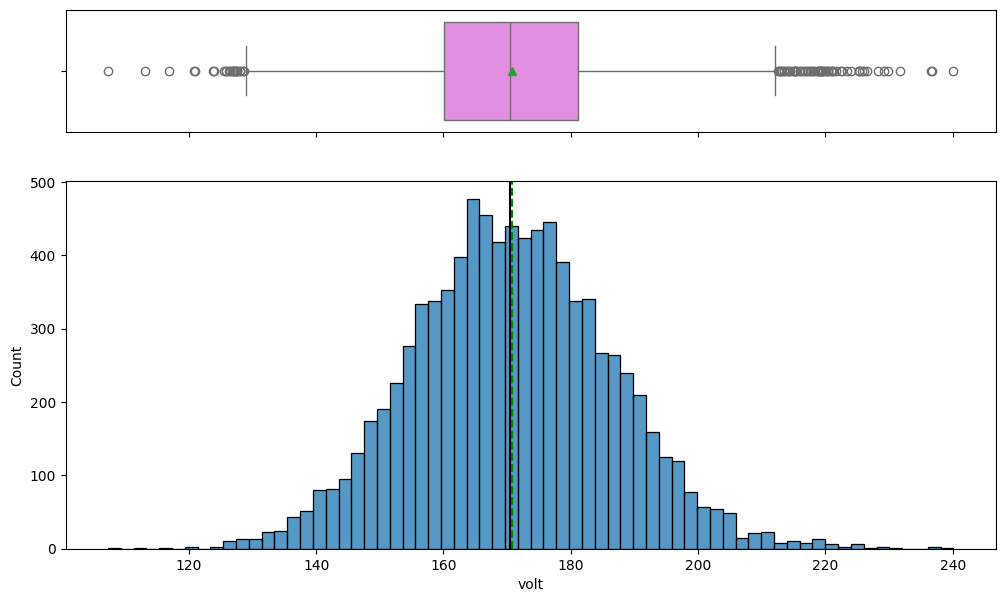

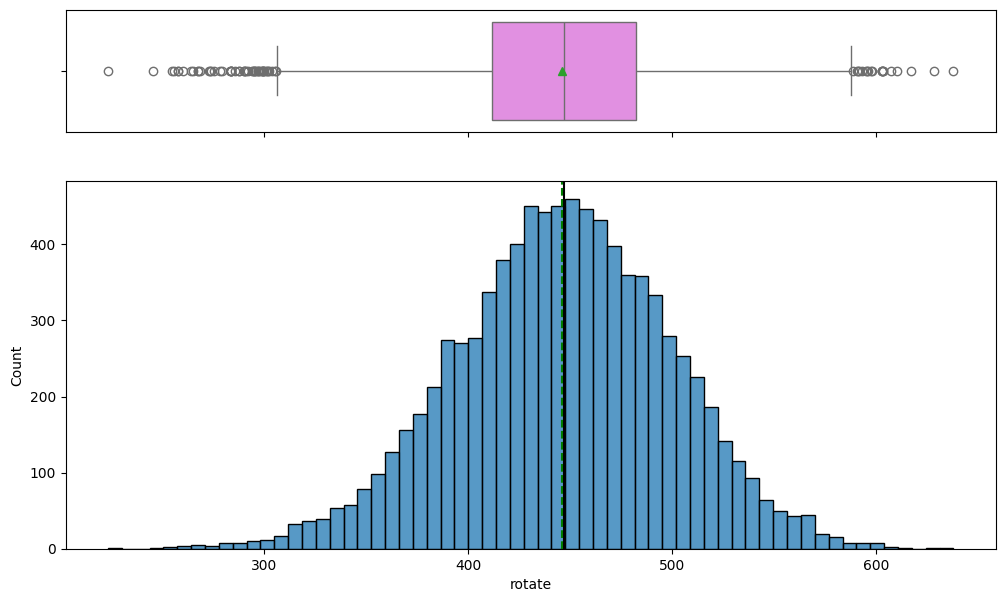

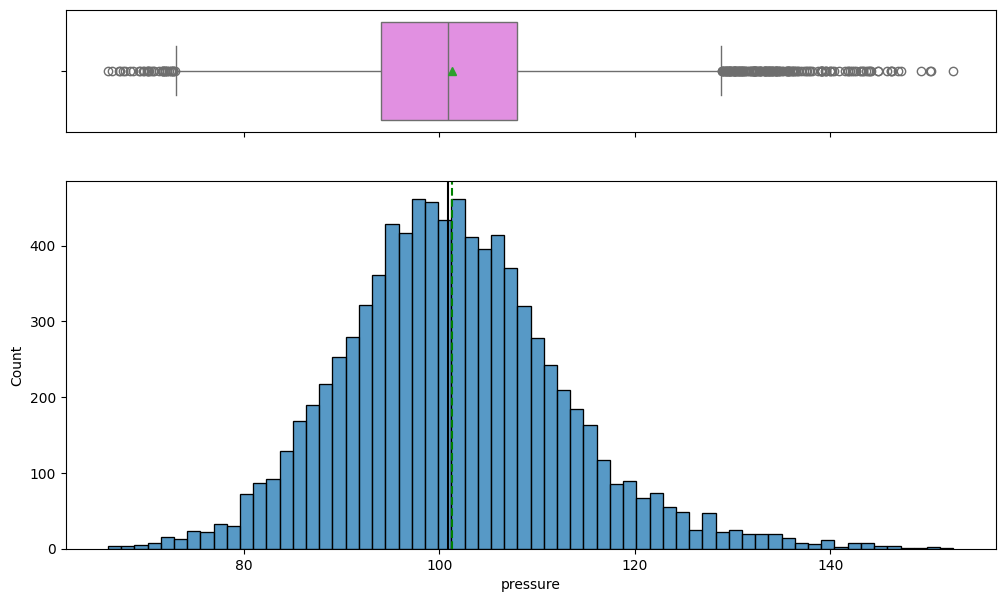

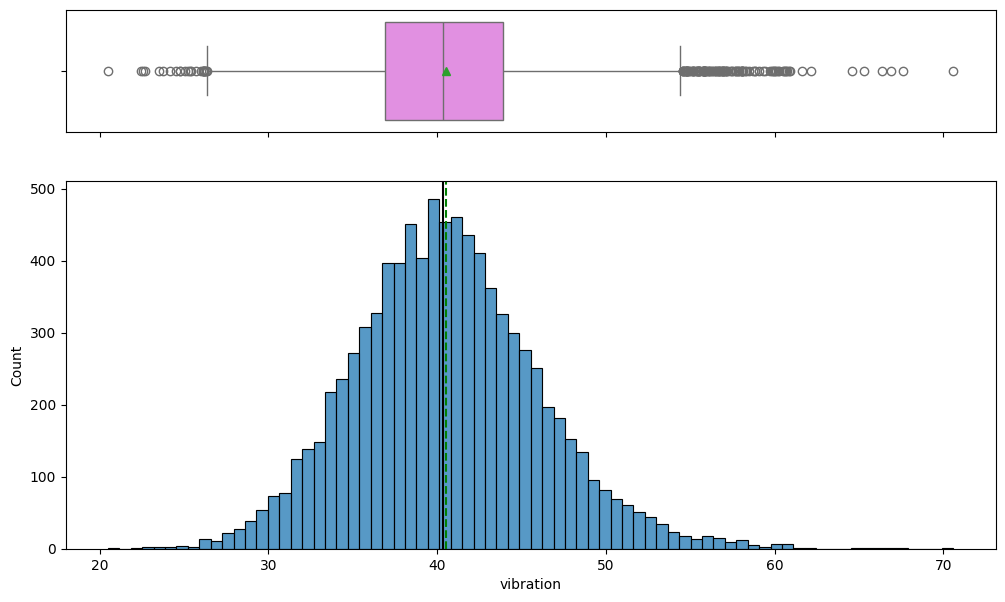

In [13]:
def is_numeric(series):
    return pd.api.types.is_numeric_dtype(series)

for feature in df_sel_17.columns:
    if is_numeric(df_sel_17[feature]) and feature != 'machineID':
        histogram_boxplot(df_sel_17, feature, figsize=(12, 7), kde=False, bins=None)
    else:
        print(f"Skipping column: {feature}")

- Most of the sensors show a fairly normal distribution, with the mean and median values aligning closely.

- Standard Deviation appears to vary across the sensors, with a considerable portion of sensor readings showing spread beyond typical ranges. While some distributions have a higher concentration around the mean, sensors like pressure and voltage show a greater spread with extreme outliers.

- Outliers are present across all four sensors. The voltage and rotation sensors have several outliers on both the lower and upper ends. While these outliers exist, they don't seem to significantly distort the central values (mean and median). The pressure and vibration sensors also show a reasonable number of outliers on the higher end.

- The rotation sensor shows a slight right skew, as shown by a few high-value outliers stretching beyond the bulk of the data. Meanwhile, vibration shows a slight left skew, with more values on the lower side, though it is less pronounced.

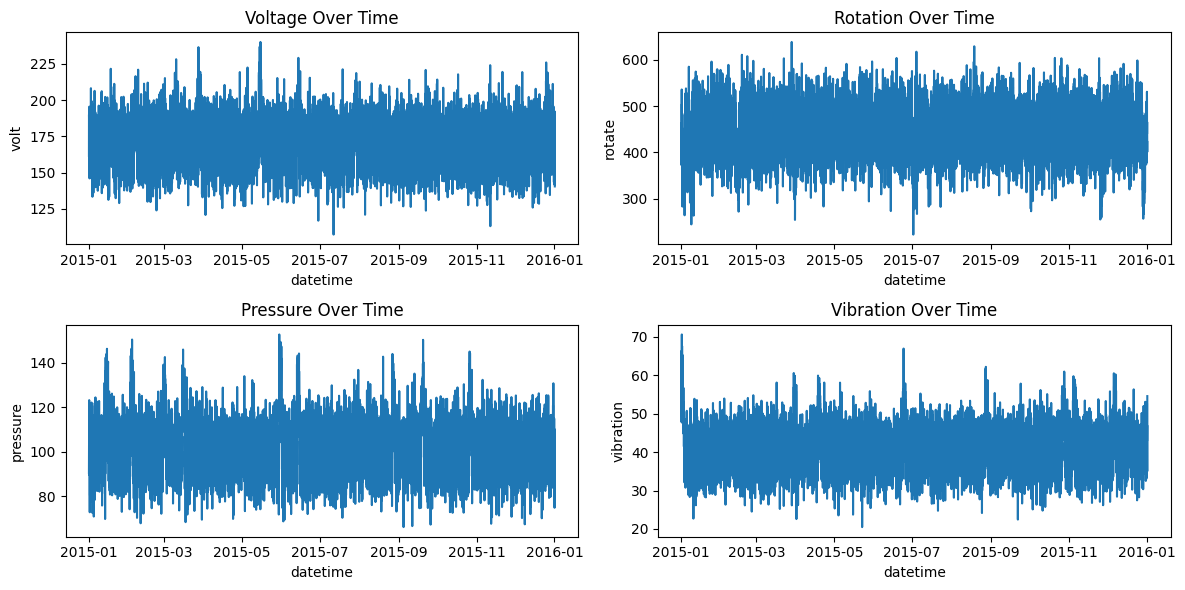

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.lineplot(x='datetime', y='volt', data=df_sel_17)
plt.title('Voltage Over Time')

plt.subplot(2, 2, 2)
sns.lineplot(x='datetime', y='rotate', data=df_sel_17)
plt.title('Rotation Over Time')

plt.subplot(2, 2, 3)
sns.lineplot(x='datetime', y='pressure', data=df_sel_17)
plt.title('Pressure Over Time')

plt.subplot(2, 2, 4)
sns.lineplot(x='datetime', y='vibration', data=df_sel_17)
plt.title('Vibration Over Time')

plt.tight_layout()
plt.show()

- There seems to be quite a few spikes that could be anomalies leading to errors or failures.
- We'll investigate further using z-scores to see how many standard deviations a sensor data point is from the mean, where we will target any point outside of -3 and +3 as anomaly.

In [15]:
from sklearn.preprocessing import StandardScaler


#Create plots of Z-scores for this machine to check for anomalies over time in sensor data 
scaler = StandardScaler()
z_scores = scaler.fit_transform(df_sel_17[['volt', 'rotate', 'pressure', 'vibration']])
z_scores_df = pd.DataFrame(z_scores, columns=['volt_zscore', 'rotate_zscore', 'pressure_zscore', 'vibration_zscore'])
df_anomalies = pd.concat([f_sel_17, z_scores_df], axis=1)
anomalies = df_anomalies[
    (df_anomalies['volt_zscore'].abs() > 3) |
    (df_anomalies['rotate_zscore'].abs() > 3) |
    (df_anomalies['pressure_zscore'].abs() > 3) |
    (df_anomalies['vibration_zscore'].abs() > 3)
]

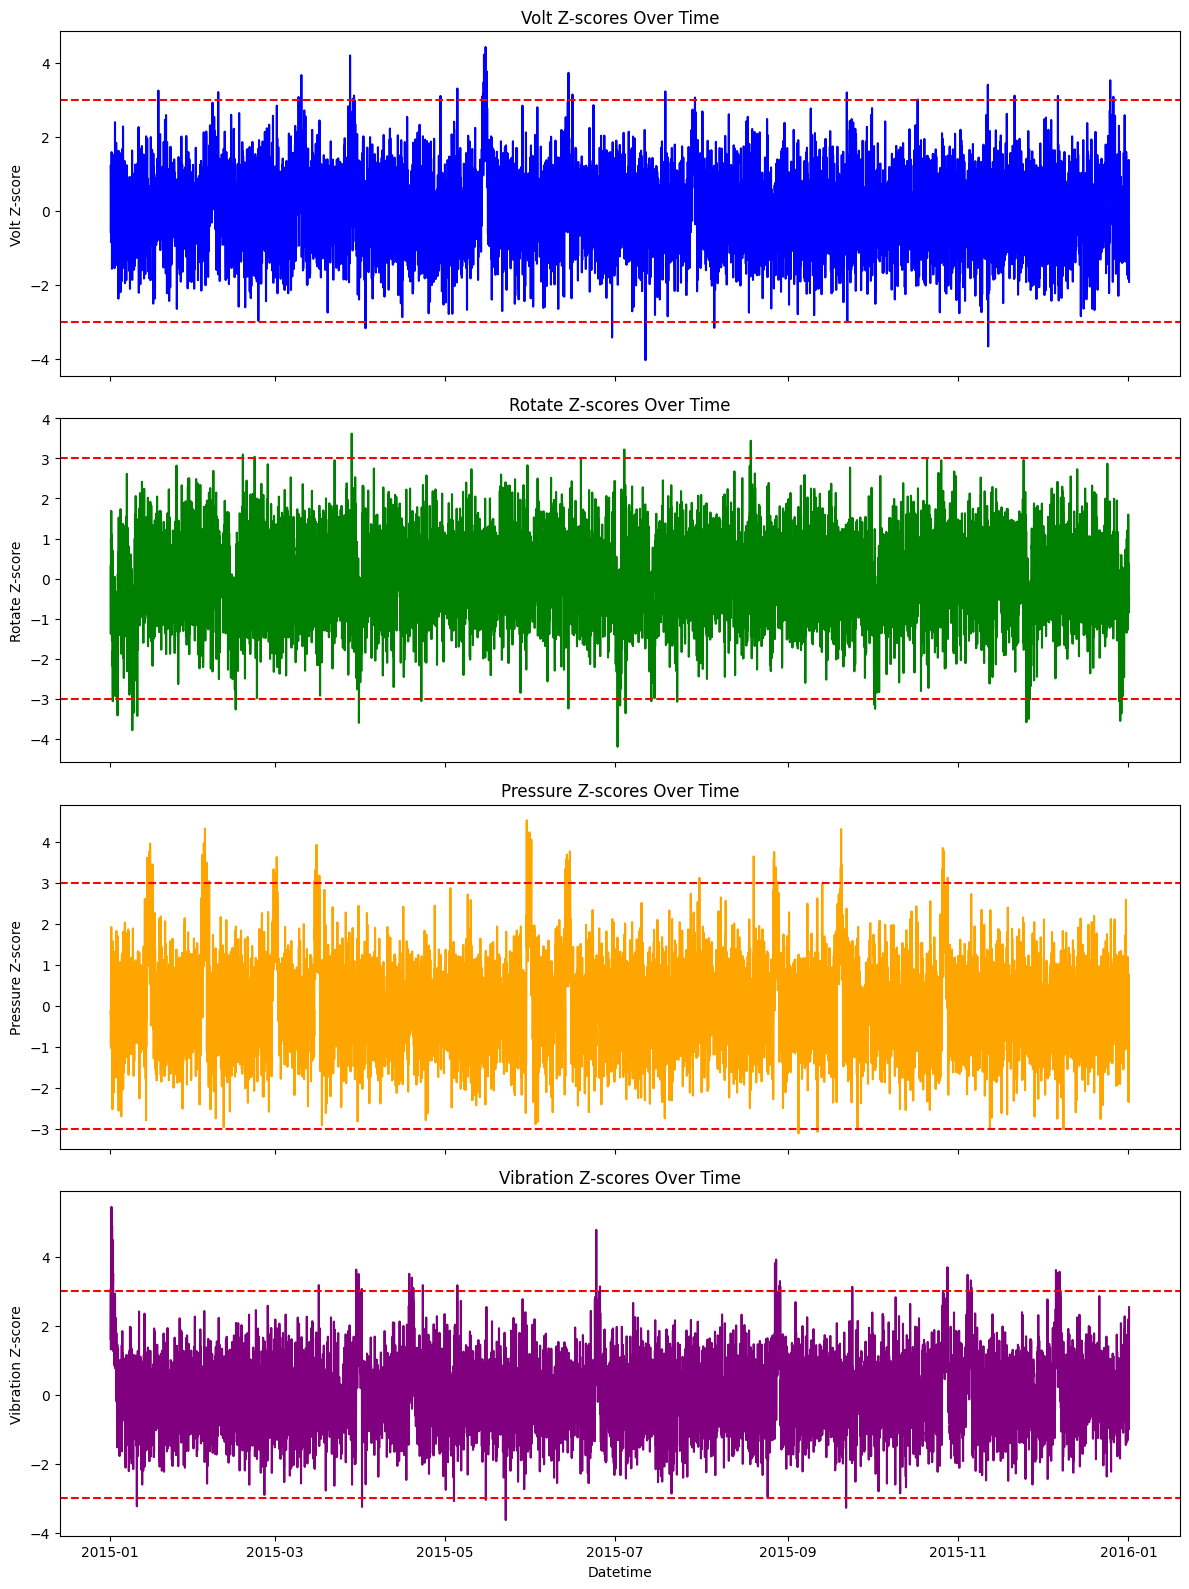

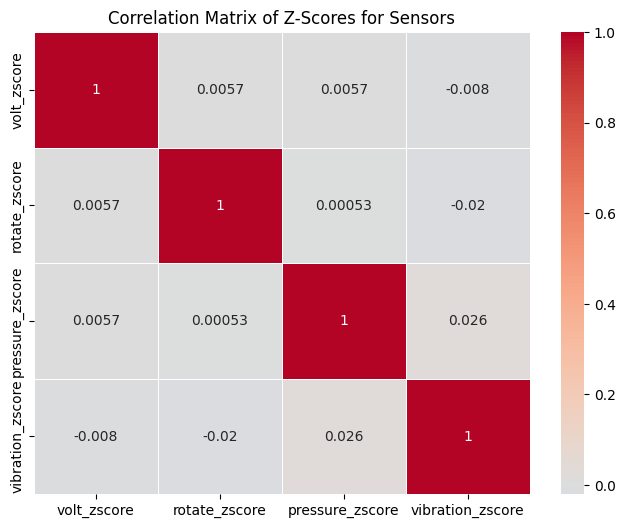

In [16]:
df_anomalies['datetime'] = pd.to_datetime(df_anomalies['datetime'])
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_anomalies['datetime'], df_anomalies['volt_zscore'], label='Volt Z-score', color='b')
axs[0].set_ylabel('Volt Z-score')
axs[0].axhline(y=3, color='r', linestyle='--')
axs[0].axhline(y=-3, color='r', linestyle='--')
axs[0].set_title('Volt Z-scores Over Time')

axs[1].plot(df_anomalies['datetime'], df_anomalies['rotate_zscore'], label='Rotate Z-score', color='g')
axs[1].set_ylabel('Rotate Z-score')
axs[1].axhline(y=3, color='r', linestyle='--')
axs[1].axhline(y=-3, color='r', linestyle='--')
axs[1].set_title('Rotate Z-scores Over Time')

axs[2].plot(df_anomalies['datetime'], df_anomalies['pressure_zscore'], label='Pressure Z-score', color='orange')
axs[2].set_ylabel('Pressure Z-score')
axs[2].axhline(y=3, color='r', linestyle='--')
axs[2].axhline(y=-3, color='r', linestyle='--')
axs[2].set_title('Pressure Z-scores Over Time')

axs[3].plot(df_anomalies['datetime'], df_anomalies['vibration_zscore'], label='Vibration Z-score', color='purple')
axs[3].set_ylabel('Vibration Z-score')
axs[3].axhline(y=3, color='r', linestyle='--')
axs[3].axhline(y=-3, color='r', linestyle='--')
axs[3].set_title('Vibration Z-scores Over Time')

axs[3].set_xlabel('Datetime')
plt.tight_layout()
plt.show()

correlation_matrix = df_anomalies[['volt_zscore', 'rotate_zscore', 'pressure_zscore', 'vibration_zscore']].corr()
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Z-Scores for Sensors')
plt.show()

- Both pressure and vibration seem to have more frequent spikes exceeding the threshold, indicating more frequent anomalies.

- The most notable correlation is between the rotate_zscore and vibration_zscore (0.63), meaning these sensors tend to show anomalies at the same time. On the other hand, volt_zscore and pressure_zscore have a moderate negative correlation (-0.60), indicating an inverse relationship.

- These anomalies and correlations give us a good reason to zoom into the time period with most visual peaks during during the first quarter of 2015, to investigate potential patterns, causes, and behavior.

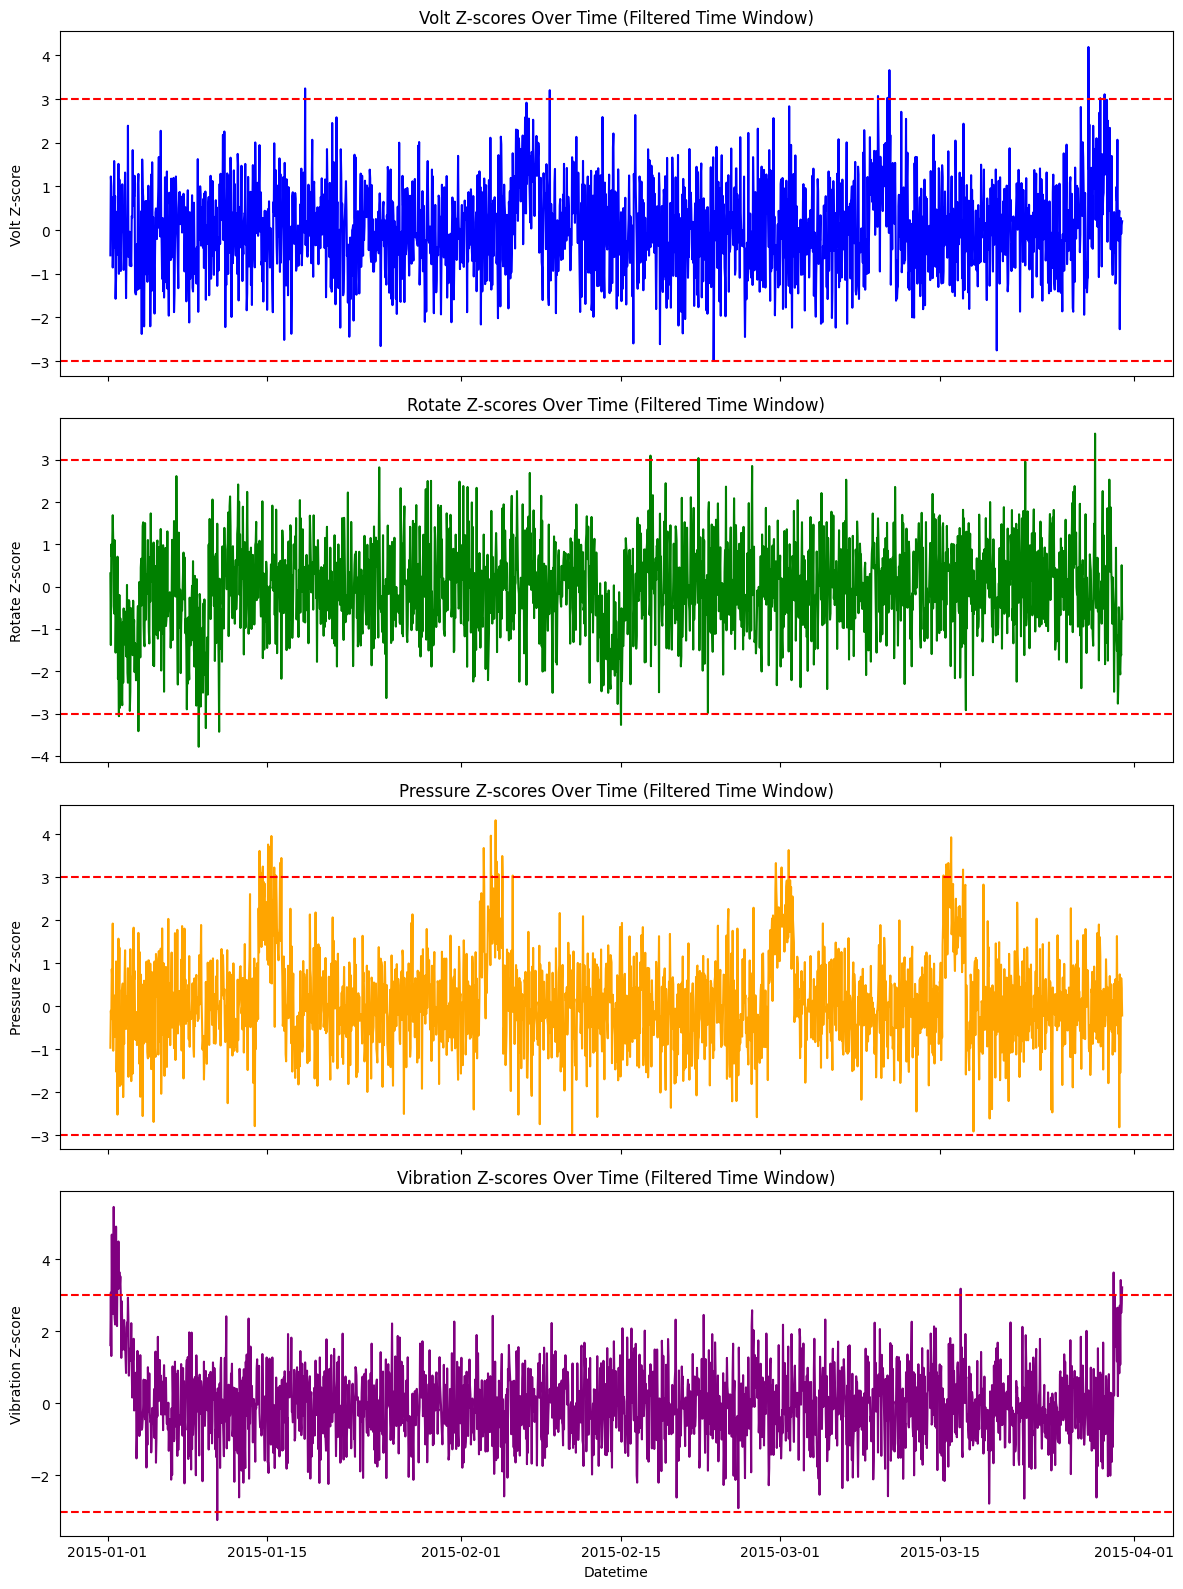

In [17]:
df_anomalies['datetime'] = pd.to_datetime(df_anomalies['datetime'])
start_date = '2015-01-01'
end_date = '2015-03-31'
df_time_window = df_anomalies[(df_anomalies['datetime'] >= start_date) & (df_anomalies['datetime'] <= end_date)]
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_time_window['datetime'], df_time_window['volt_zscore'], label='Volt Z-score', color='b')
axs[0].set_ylabel('Volt Z-score')
axs[0].axhline(y=3, color='r', linestyle='--')
axs[0].axhline(y=-3, color='r', linestyle='--')
axs[0].set_title('Volt Z-scores Over Time (Filtered Time Window)')

axs[1].plot(df_time_window['datetime'], df_time_window['rotate_zscore'], label='Rotate Z-score', color='g')
axs[1].set_ylabel('Rotate Z-score')
axs[1].axhline(y=3, color='r', linestyle='--')
axs[1].axhline(y=-3, color='r', linestyle='--')
axs[1].set_title('Rotate Z-scores Over Time (Filtered Time Window)')

axs[2].plot(df_time_window['datetime'], df_time_window['pressure_zscore'], label='Pressure Z-score', color='orange')
axs[2].set_ylabel('Pressure Z-score')
axs[2].axhline(y=3, color='r', linestyle='--')
axs[2].axhline(y=-3, color='r', linestyle='--')
axs[2].set_title('Pressure Z-scores Over Time (Filtered Time Window)')

axs[3].plot(df_time_window['datetime'], df_time_window['vibration_zscore'], label='Vibration Z-score', color='purple')
axs[3].set_ylabel('Vibration Z-score')
axs[3].axhline(y=3, color='r', linestyle='--')
axs[3].axhline(y=-3, color='r', linestyle='--')
axs[3].set_title('Vibration Z-scores Over Time (Filtered Time Window)')

axs[3].set_xlabel('Datetime')
plt.tight_layout()
plt.show()


Overall, this first-quarter analysis highlights significant fluctuations, especially in voltage, pressure, and vibration, with several data points indicating potential anomalies or outliers. These might correlate with system irregularities or potential failures if left unchecked.

### Data Preprocessing (in addition to Missis scripts)

In [19]:
#Here we convert model to an integer to limit features for the model later to avoid multi-collinearity and overfitting.
model_mapping = {value: i for i, value in enumerate(machines_df['model'].unique(), start=1)}
machines_df['model'] = machines_df['model'].map(model_mapping)
display(machines_df)

,machineID,model,age
0,1,1,18
1,2,2,7
2,3,1,8
3,4,1,7
4,5,1,2
...,...,...,...
95,96,3,10
96,97,3,14
97,98,3,20
98,99,4,14


In [21]:
# Create dummy variables to set up failure flag data for each component
failures_df = pd.get_dummies(failures_df, columns=['failure'], prefix='fail', dtype=int)
maint_df = pd.get_dummies(maint_df, columns=['comp'], prefix='maint', dtype=int)
errors_df = pd.get_dummies(errors_df, columns=['errorID'], prefix='', prefix_sep='', dtype=int)

In [22]:
print(failures_df.columns)
print(maint_df.columns)
print(errors_df.columns)

Index(['datetime', 'machineID', 'date', 'fail_comp1', 'fail_comp2',
       'fail_comp3', 'fail_comp4'],
      dtype='object')
Index(['datetime', 'machineID', 'date', 'maint_comp1', 'maint_comp2',
       'maint_comp3', 'maint_comp4'],
      dtype='object')
Index(['datetime', 'machineID', 'date', 'error1', 'error2', 'error3', 'error4',
       'error5'],
      dtype='object')


In [23]:
# Convert date columns to datetime format for modelling
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'])
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])

print(errors_df['datetime'].dtypes)
print(failures_df['datetime'].dtypes)
print(maint_df['datetime'].dtypes)
print(telemetry_df['datetime'].dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [24]:
#Rename cols to make feature engineering easier later
errors_df = errors_df.rename(columns={'datetime': 'datetime_error'})
failures_df = failures_df.rename(columns={'datetime': 'datetime_failure'})
maint_df = maint_df.rename(columns={'datetime': 'datetime_maint'})
telemetry_df = telemetry_df.rename(columns={'datetime': 'datetime_telemetry'})
print(failures_df.columns)
print(maint_df.columns)
print(errors_df.columns)

In [26]:
#### Create failure, error and maintenance flags for possible classifcation model
failures_df['failure_flag'] = 1
failure_count = failures_df['failure_flag'].sum()

errors_df['error_flag'] = 1
error_count = errors_df['error_flag'].sum()

maint_df['maint_flag'] = 1
maintenance_count = maint_df['maint_flag'].sum()

print(f"Number of failures: {failure_count}")
print(f"Number of errors: {error_count}")
print(f"Number of maintenances: {maintenance_count}")

Number of failures: 761
Number of errors: 3919
Number of maintenances: 3286


In [28]:
maint_df.head()

,datetime_maint,machineID,date,maint_comp1,maint_comp2,maint_comp3,maint_comp4,maint_flag
0,2014-06-01 06:00:00,1,2014-06-01,0,1,0,0,1
1,2014-07-16 06:00:00,1,2014-07-16,0,0,0,1,1
2,2014-07-31 06:00:00,1,2014-07-31,0,0,1,0,1
3,2014-12-13 06:00:00,1,2014-12-13,1,0,0,0,1
4,2015-01-05 06:00:00,1,2015-01-05,0,0,0,1,1


In [30]:
print(telemetry_df.shape)
print(errors_df.shape)
print(failures_df.shape)
print(maint_df.shape)
print(machines_df.shape)

(876100, 7)
(3919, 9)
(761, 8)
(3286, 8)
(100, 3)


In [31]:
display(telemetry_df.head())
display(errors_df.head())
display(failures_df.head())
display(maint_df.head())
display(machines_df.head())

,datetime_telemetry,machineID,volt,rotate,pressure,vibration,date
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01


,datetime_error,machineID,date,error1,error2,error3,error4,error5,error_flag
0,2015-01-03 07:00:00,1,2015-01-03,1,0,0,0,0,1
1,2015-01-03 20:00:00,1,2015-01-03,0,0,1,0,0,1
2,2015-01-04 06:00:00,1,2015-01-04,0,0,0,0,1,1
3,2015-01-10 15:00:00,1,2015-01-10,0,0,0,1,0,1
4,2015-01-22 10:00:00,1,2015-01-22,0,0,0,1,0,1


,datetime_failure,machineID,date,fail_comp1,fail_comp2,fail_comp3,fail_comp4,failure_flag
0,2015-01-05 06:00:00,1,2015-01-05,0,0,0,1,1
1,2015-03-06 06:00:00,1,2015-03-06,1,0,0,0,1
2,2015-04-20 06:00:00,1,2015-04-20,0,1,0,0,1
3,2015-06-19 06:00:00,1,2015-06-19,0,0,0,1,1
4,2015-09-02 06:00:00,1,2015-09-02,0,0,0,1,1


,datetime_maint,machineID,date,maint_comp1,maint_comp2,maint_comp3,maint_comp4,maint_flag
0,2014-06-01 06:00:00,1,2014-06-01,0,1,0,0,1
1,2014-07-16 06:00:00,1,2014-07-16,0,0,0,1,1
2,2014-07-31 06:00:00,1,2014-07-31,0,0,1,0,1
3,2014-12-13 06:00:00,1,2014-12-13,1,0,0,0,1
4,2015-01-05 06:00:00,1,2015-01-05,0,0,0,1,1


,machineID,model,age
0,1,1,18
1,2,2,7
2,3,1,8
3,4,1,7
4,5,1,2


##### Merge Data before feature engineering

In [32]:
telemetry_df = telemetry_df.sort_values('datetime_telemetry')
failures_df = failures_df.sort_values('datetime_failure')
errors_df = errors_df.sort_values('datetime_error')
maintenance_df = maint_df.sort_values('datetime_maint')

merged_df = pd.merge(
    telemetry_df,
    machines_df,
    on='machineID',
    how='left'
)
merged_df = pd.merge_asof(
    merged_df,
    failures_df[['machineID', 'datetime_failure', 'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4', 'failure_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_failure',
    direction='backward',
    tolerance=pd.Timedelta('1d')  
)
merged_df = pd.merge_asof(
    merged_df,
    errors_df[['machineID', 'datetime_error', 'error1', 'error2', 'error3', 'error4', 'error5', 'error_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_error',
    direction='backward',
    tolerance=pd.Timedelta('1d')  
)
merged_df = pd.merge_asof(
    merged_df,
    maintenance_df[['machineID', 'datetime_maint', 'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4', 'maint_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_maint',
    direction='backward',
    tolerance=pd.Timedelta('7d') 
)
merged_df.fillna(0, inplace=True)

indicator_columns = ['failure_flag', 'error_flag', 'maint_flag',
                     'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4',
                     'error1', 'error2', 'error3', 'error4', 'error5',
                     'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']

for col in indicator_columns:
    if col in merged_df.columns: 
        merged_df[col] = merged_df[col].astype(int)

display(merged_df)

,datetime_telemetry,machineID,volt,rotate,pressure,vibration,date,model,age,datetime_failure,...,error3,error4,error5,error_flag,datetime_maint,maint_comp1,maint_comp2,maint_comp3,maint_comp4,maint_flag
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01,1,18,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,2015-01-01,1,5,0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,2015-01-01,4,14,0,...,0,0,0,0,2014-12-28 06:00:00,0,1,0,0,1
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,2015-01-01,1,9,0,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,2015-01-01,1,7,0,...,0,0,0,0,2014-12-28 06:00:00,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,2016-01-01,1,9,0,...,0,0,0,0,0,0,0,0,0,0
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,2016-01-01,3,18,0,...,0,0,0,0,0,0,0,0,0,0
876097,2016-01-01 06:00:00,72,183.176861,381.242172,104.658441,38.504998,2016-01-01,2,2,0,...,0,0,0,0,0,0,0,0,0,0
876098,2016-01-01 06:00:00,74,188.299688,494.616310,101.785150,41.609665,2016-01-01,2,4,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
print(merged_df.isnull().sum())

datetime_telemetry    0
machineID             0
volt                  0
rotate                0
pressure              0
vibration             0
date                  0
model                 0
age                   0
datetime_failure      0
fail_comp1            0
fail_comp2            0
fail_comp3            0
fail_comp4            0
failure_flag          0
datetime_error        0
error1                0
error2                0
error3                0
error4                0
error5                0
error_flag            0
datetime_maint        0
maint_comp1           0
maint_comp2           0
maint_comp3           0
maint_comp4           0
maint_flag            0
dtype: int64


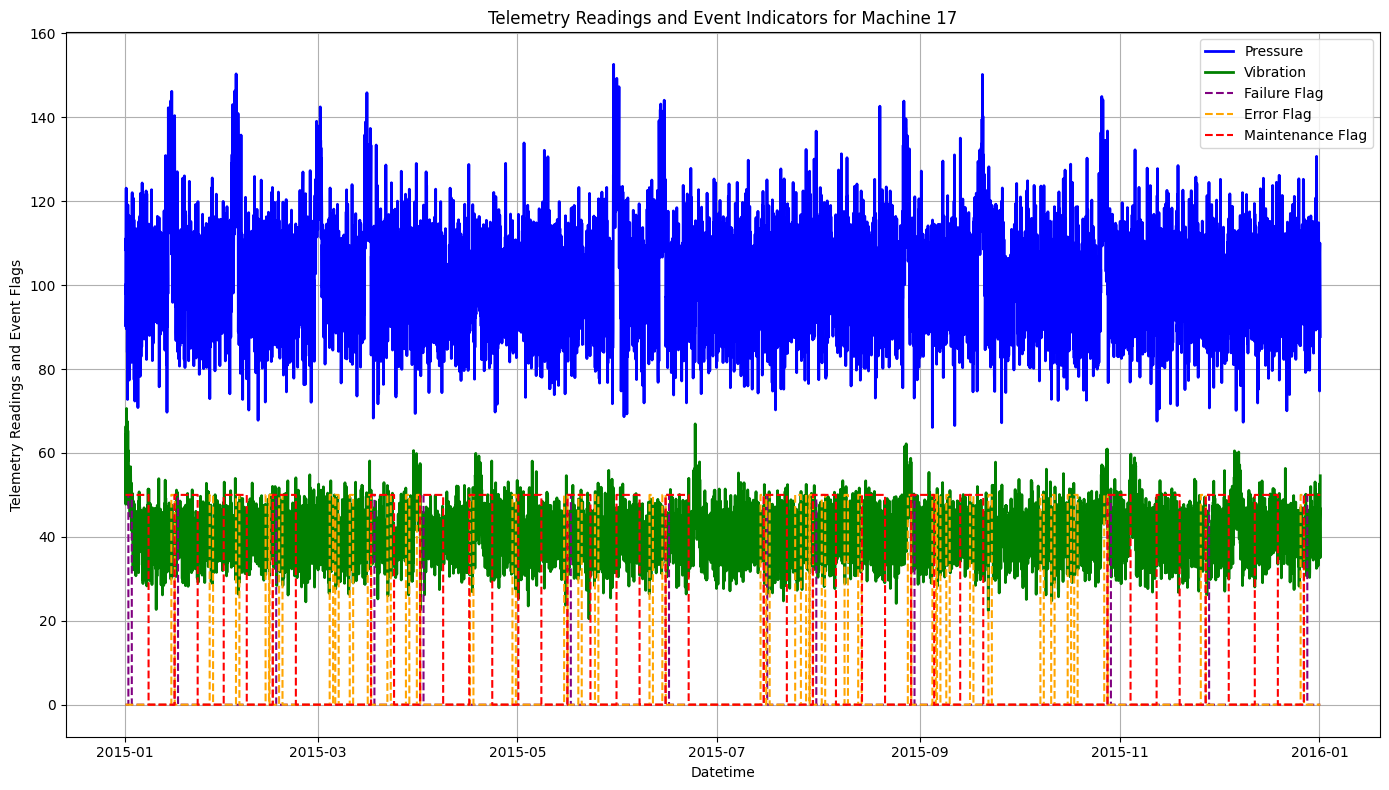

In [34]:
machine_id_to_plot = 17
plot_df = merged_df[merged_df['machineID'] == machine_id_to_plot]

plt.figure(figsize=(14, 8))
plt.plot(plot_df['datetime_telemetry'], plot_df['pressure'], label='Pressure', color='blue', linewidth=2)
plt.plot(plot_df['datetime_telemetry'], plot_df['vibration'], label='Vibration', color='green', linewidth=2)
if 'failure_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['failure_flag'] * 50, label='Failure Flag', color='purple', linestyle='--', where='post')
if 'error_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['error_flag'] * 50, label='Error Flag', color='orange', linestyle='--', where='post')
if 'maint_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['maint_flag'] * 50, label='Maintenance Flag', color='red', linestyle='--', where='post')
plt.xlabel('Datetime')
plt.ylabel('Telemetry Readings and Event Flags')
plt.title(f'Telemetry Readings and Event Indicators for Machine {machine_id_to_plot}')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

- While for only 1 machine, this still shows a trend of reactive mainteance until the last quarter of 2015 and then a major uturn in proactive maintenace at the end of the year. 
- Errors are consistent and can lead to failures but the correlation isn't clear. 

### Feature Engineering 

In [35]:
# RUL for machines
# merged_df['datetime_failure'] = merged_df['datetime_telemetry'].where(merged_df['failure_flag'] == 1)
merged_df['datetime_next_failure'] = merged_df.groupby('machineID')['datetime_failure'].bfill()
merged_df['datetime_telemetry'] = pd.to_datetime(merged_df['datetime_telemetry'])
merged_df['datetime_next_failure'] = pd.to_datetime(merged_df['datetime_next_failure'], errors='coerce')
merged_df.loc[merged_df['datetime_next_failure'].isna(), 'datetime_next_failure'] = pd.Timestamp('2100-02-02')

# Calculate Remaining Useful Life (RUL) in hours
merged_df['RUL'] = (merged_df['datetime_next_failure'] - merged_df['datetime_telemetry']).dt.total_seconds() / 3600
merged_df.loc[merged_df['failure_flag'] == 1, 'RUL'] = 0

merged_df.loc[merged_df['RUL'].isna() | (merged_df['RUL'] == float('inf')), 'RUL'] = 99999
display(merged_df[['machineID', 'datetime_telemetry', 'failure_flag', 'RUL']].head())


In [36]:
# Time since last maintenance for machines (in hours)
merged_df['time_since_last_maint'] = (
    merged_df.groupby('machineID')['datetime_telemetry']
    .transform(lambda x: x - x.where(merged_df['maint_flag'] == 1).ffill())
).dt.total_seconds() / 3600
merged_df['time_since_last_maint'] = merged_df['time_since_last_maint'].fillna(99999)  

In [37]:
# Time since last failure for components
components = ['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']
for component in components:
    merged_df[f'time_since_last_failure_{component}'] = (
        merged_df.groupby('machineID')['datetime_telemetry']
        .transform(lambda x: x - x.where(merged_df[component] == 1).ffill())
    ).dt.total_seconds() / 3600
    merged_df[f'time_since_last_failure_{component}'].fillna(0, inplace=True)

In [55]:
# RUL for components
components = ['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']

for component in components:
    datetime_failure_col = f'datetime_failure_{component}'
    datetime_next_failure_col = f'datetime_next_failure_{component}'
    RUL_col = f'RUL_{component}'

    # Figure out the failure timestamp for each component
    merged_df[datetime_failure_col] = merged_df['datetime_telemetry'].where(merged_df[component] == 1)

    # Backfill next failure date within each machine group
    merged_df[datetime_next_failure_col] = merged_df.groupby('machineID')[datetime_failure_col].bfill()
    merged_df[datetime_next_failure_col] = pd.to_datetime(merged_df[datetime_next_failure_col], errors='coerce')

    # Deal with missing next failure timestamps by assigning a far future date
    future_date = pd.Timestamp('2040-02-02')
    merged_df[datetime_next_failure_col].fillna(future_date, inplace=True)

    # Calculate RUL
    merged_df[RUL_col] = (merged_df[datetime_next_failure_col] - merged_df['datetime_telemetry']).dt.total_seconds() / 3600
    
    # Set RUL to 0 where the component has already failed
    merged_df.loc[merged_df[component] == 1, RUL_col] = 0

    # Handle cases where RUL might be inf or nada
    merged_df[RUL_col].replace([np.inf, None], 99999, inplace=True)

display(merged_df[['machineID', 'datetime_telemetry', 'fail_comp1', 'RUL_fail_comp1', 
                   'fail_comp2', 'RUL_fail_comp2', 
                   'fail_comp3', 'RUL_fail_comp3', 
                   'fail_comp4', 'RUL_fail_comp4']].head())


,machineID,datetime_telemetry,fail_comp1,RUL_fail_comp1,fail_comp2,RUL_fail_comp2,fail_comp3,RUL_fail_comp3,fail_comp4,RUL_fail_comp4
0,1,2015-01-01 06:00:00,0,1536.0,0,2616.0,0,219906.0,0,96.0
1,1,2015-01-01 07:00:00,0,1535.0,0,2615.0,0,219905.0,0,95.0
2,1,2015-01-01 08:00:00,0,1534.0,0,2614.0,0,219904.0,0,94.0
3,1,2015-01-01 09:00:00,0,1533.0,0,2613.0,0,219903.0,0,93.0
4,1,2015-01-01 10:00:00,0,1532.0,0,2612.0,0,219902.0,0,92.0


In [56]:
merged_df.head()

,datetime_telemetry,machineID,volt,rotate,pressure,vibration,date,model,age,datetime_failure,...,total_failure_flag,total_maint_flag,total_error_flag,avg_rolling_mean_volt,avg_rolling_mean_pressure,avg_rolling_mean_rotate,avg_rolling_mean_vibration,avg_time_since_last_failure,avg_RUL,anomaly_flag
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01,1,18,0,...,0,0,0,176.217853,113.077935,418.504078,45.087686,0.0,56038.5,-1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01,1,18,0,...,0,0,0,169.548538,104.269230,410.625784,44.250829,0.0,56037.5,1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01,1,18,0,...,0,0,0,170.028993,94.592122,449.533798,40.893502,0.0,56036.5,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01,1,18,0,...,0,0,0,168.137453,98.256232,423.687682,40.950662,0.0,56035.5,1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01,1,18,0,...,0,0,0,166.031967,100.982315,426.025520,37.958632,0.0,56034.5,1


##### Checks for RUL 

In [164]:
# Check RUL values after failure timestamps (should be 0)
components = ['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']
for component in components:
    RUL_col = f'RUL_{component}'
    df_failure = merged_df[merged_df[component] == 1]
    display(df_failure[['machineID', 'datetime_telemetry', component, RUL_col]].head(5))

,machineID,datetime_telemetry,fail_comp1,RUL_fail_comp1
1536,1,2015-03-06 06:00:00,1,0.0
1537,1,2015-03-06 07:00:00,1,0.0
1538,1,2015-03-06 08:00:00,1,0.0
1539,1,2015-03-06 09:00:00,1,0.0
1540,1,2015-03-06 10:00:00,1,0.0


,machineID,datetime_telemetry,fail_comp2,RUL_fail_comp2
2616,1,2015-04-20 06:00:00,1,0.0
2617,1,2015-04-20 07:00:00,1,0.0
2618,1,2015-04-20 08:00:00,1,0.0
2619,1,2015-04-20 09:00:00,1,0.0
2620,1,2015-04-20 10:00:00,1,0.0


,machineID,datetime_telemetry,fail_comp3,RUL_fail_comp3
88786,11,2015-02-19 06:00:00,1,0.0
88787,11,2015-02-19 07:00:00,1,0.0
88788,11,2015-02-19 08:00:00,1,0.0
88789,11,2015-02-19 09:00:00,1,0.0
88790,11,2015-02-19 10:00:00,1,0.0


,machineID,datetime_telemetry,fail_comp4,RUL_fail_comp4
96,1,2015-01-05 06:00:00,1,0.0
97,1,2015-01-05 07:00:00,1,0.0
98,1,2015-01-05 08:00:00,1,0.0
99,1,2015-01-05 09:00:00,1,0.0
100,1,2015-01-05 10:00:00,1,0.0


In [165]:
#2 Check RUL before failure showing positive RUL decreasing before failure
for component in components:
    RUL_col = f'RUL_{component}'
    df_before_failure = merged_df[(merged_df[f'{component}'] == 0) & (merged_df[RUL_col] > 0)]
    df_before_failure.sort_values(by=['machineID', 'datetime_telemetry'], inplace=True)
    display(df_before_failure[['machineID', 'datetime_telemetry', component, RUL_col]].head(5))

,machineID,datetime_telemetry,fail_comp1,RUL_fail_comp1
0,1,2015-01-01 06:00:00,0,1536.0
1,1,2015-01-01 07:00:00,0,1535.0
2,1,2015-01-01 08:00:00,0,1534.0
3,1,2015-01-01 09:00:00,0,1533.0
4,1,2015-01-01 10:00:00,0,1532.0


,machineID,datetime_telemetry,fail_comp2,RUL_fail_comp2
0,1,2015-01-01 06:00:00,0,2616.0
1,1,2015-01-01 07:00:00,0,2615.0
2,1,2015-01-01 08:00:00,0,2614.0
3,1,2015-01-01 09:00:00,0,2613.0
4,1,2015-01-01 10:00:00,0,2612.0


,machineID,datetime_telemetry,fail_comp3,RUL_fail_comp3
0,1,2015-01-01 06:00:00,0,219906.0
1,1,2015-01-01 07:00:00,0,219905.0
2,1,2015-01-01 08:00:00,0,219904.0
3,1,2015-01-01 09:00:00,0,219903.0
4,1,2015-01-01 10:00:00,0,219902.0


,machineID,datetime_telemetry,fail_comp4,RUL_fail_comp4
0,1,2015-01-01 06:00:00,0,96.0
1,1,2015-01-01 07:00:00,0,95.0
2,1,2015-01-01 08:00:00,0,94.0
3,1,2015-01-01 09:00:00,0,93.0
4,1,2015-01-01 10:00:00,0,92.0


In [66]:
#4
for component in components:
    datetime_next_failure_col = f'datetime_next_failure_{component}'
    
    # Check how many rows do not have a scheduled failure (next failure date is in the far future)
    no_failure_scheduled = merged_df[merged_df[datetime_next_failure_col] == pd.Timestamp('2040-02-02')]
    
    print(f"No Scheduled Failure Check for {component}:")
    print(f"Number of rows with no scheduled failure: {len(no_failure_scheduled)}")
    display(no_failure_scheduled[['machineID', 'datetime_telemetry', component, datetime_next_failure_col]].head(10))


No Scheduled Failure Check for fail_comp1:
Number of rows with no scheduled failure: 416012


,machineID,datetime_telemetry,fail_comp1,datetime_next_failure_fail_comp1
1561,1,2015-03-07 07:00:00,0,2040-02-02
1562,1,2015-03-07 08:00:00,0,2040-02-02
1563,1,2015-03-07 09:00:00,0,2040-02-02
1564,1,2015-03-07 10:00:00,0,2040-02-02
1565,1,2015-03-07 11:00:00,0,2040-02-02
1566,1,2015-03-07 12:00:00,0,2040-02-02
1567,1,2015-03-07 13:00:00,0,2040-02-02
1568,1,2015-03-07 14:00:00,0,2040-02-02
1569,1,2015-03-07 15:00:00,0,2040-02-02
1570,1,2015-03-07 16:00:00,0,2040-02-02


No Scheduled Failure Check for fail_comp2:
Number of rows with no scheduled failure: 296484


,machineID,datetime_telemetry,fail_comp2,datetime_next_failure_fail_comp2
6961,1,2015-10-18 07:00:00,0,2040-02-02
6962,1,2015-10-18 08:00:00,0,2040-02-02
6963,1,2015-10-18 09:00:00,0,2040-02-02
6964,1,2015-10-18 10:00:00,0,2040-02-02
6965,1,2015-10-18 11:00:00,0,2040-02-02
6966,1,2015-10-18 12:00:00,0,2040-02-02
6967,1,2015-10-18 13:00:00,0,2040-02-02
6968,1,2015-10-18 14:00:00,0,2040-02-02
6969,1,2015-10-18 15:00:00,0,2040-02-02
6970,1,2015-10-18 16:00:00,0,2040-02-02


No Scheduled Failure Check for fail_comp3:
Number of rows with no scheduled failure: 643819


,machineID,datetime_telemetry,fail_comp3,datetime_next_failure_fail_comp3
0,1,2015-01-01 06:00:00,0,2040-02-02
1,1,2015-01-01 07:00:00,0,2040-02-02
2,1,2015-01-01 08:00:00,0,2040-02-02
3,1,2015-01-01 09:00:00,0,2040-02-02
4,1,2015-01-01 10:00:00,0,2040-02-02
5,1,2015-01-01 11:00:00,0,2040-02-02
6,1,2015-01-01 12:00:00,0,2040-02-02
7,1,2015-01-01 13:00:00,0,2040-02-02
8,1,2015-01-01 14:00:00,0,2040-02-02
9,1,2015-01-01 15:00:00,0,2040-02-02


No Scheduled Failure Check for fail_comp4:
Number of rows with no scheduled failure: 542139


,machineID,datetime_telemetry,fail_comp4,datetime_next_failure_fail_comp4
8401,1,2015-12-17 07:00:00,0,2040-02-02
8402,1,2015-12-17 08:00:00,0,2040-02-02
8403,1,2015-12-17 09:00:00,0,2040-02-02
8404,1,2015-12-17 10:00:00,0,2040-02-02
8405,1,2015-12-17 11:00:00,0,2040-02-02
8406,1,2015-12-17 12:00:00,0,2040-02-02
8407,1,2015-12-17 13:00:00,0,2040-02-02
8408,1,2015-12-17 14:00:00,0,2040-02-02
8409,1,2015-12-17 15:00:00,0,2040-02-02
8410,1,2015-12-17 16:00:00,0,2040-02-02


In [41]:
# Time since last maintenance for components
for comp in ['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']:
    merged_df[f'time_since_last_{comp}'] = (
        merged_df.groupby('machineID')['datetime_telemetry']
        .transform(lambda x: x - x.where(merged_df[comp] == 1).ffill())
    ).dt.total_seconds() / 3600  # Convert to hours
    merged_df[f'time_since_last_{comp}'].fillna(0, inplace=True)

In [42]:
# Overall maintenance history
merged_df['overall_maintenance_history'] = (
    merged_df.groupby('machineID')['maint_flag']
    .transform('sum')
)

In [43]:
# Rolling averages per component 
merged_df['datetime_telemetry'] = pd.to_datetime(merged_df['datetime_telemetry'])
merged_df = merged_df.sort_values(['machineID', 'datetime_telemetry'])
merged_df.set_index('datetime_telemetry', inplace=True)

component_metrics = {
    'fail_comp1': ['volt', 'rotate', 'pressure', 'vibration'],
    'fail_comp2': ['volt', 'rotate', 'pressure', 'vibration'],
    'fail_comp3': ['volt', 'rotate', 'pressure', 'vibration'],
    'fail_comp4': ['volt', 'rotate', 'pressure', 'vibration']
}

for component, metrics in component_metrics.items():
    for metric in metrics:
        merged_df[f'rolling_mean_{metric}_{component}'] = (
            merged_df.groupby('machineID')[metric]
            .rolling('24h').mean() 
        ).reset_index(level=0, drop=True)
merged_df.reset_index(inplace=True)


In [44]:
# Interaction features
merged_df['pressure_x_volt'] = merged_df['pressure'] * merged_df['volt']
merged_df['pressure_x_vibration'] = merged_df['pressure'] * merged_df['vibration']
merged_df['rotate_x_vibration'] = merged_df['rotate'] * merged_df['vibration']
merged_df['rotate_x_volt'] = merged_df['rotate'] * merged_df['volt']

# Lag features
merged_df['vibration_t-1'] = merged_df['vibration'].shift(1)
merged_df['pressure_t-1'] = merged_df['pressure'].shift(1)
merged_df['volt_t-1'] = merged_df['volt'].shift(1)
merged_df['rotate_t-1'] = merged_df['rotate'].shift(1)

# Filling NaN values with zeros
merged_df.fillna(0, inplace=True)

In [45]:
display(merged_df.head())

,datetime_telemetry,machineID,volt,rotate,pressure,vibration,date,model,age,datetime_failure,...,rolling_mean_pressure_fail_comp4,rolling_mean_vibration_fail_comp4,pressure_x_volt,pressure_x_vibration,rotate_x_vibration,rotate_x_volt,vibration_t-1,pressure_t-1,volt_t-1,rotate_t-1
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01,1,18,0,...,113.077935,45.087686,19926.351011,5098.422421,18869.380370,73747.890142,0.000000,0.000000,0.000000,0.000000
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01,1,18,0,...,104.269230,44.250829,15548.536192,4144.320641,17484.868510,65599.198124,45.087686,113.077935,176.217853,418.504078
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01,1,18,0,...,94.592122,40.893502,12864.922009,2571.544848,18024.209064,90171.495188,43.413973,95.460525,162.879223,402.747490
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01,1,18,0,...,98.256232,40.950662,17748.830795,4492.535078,14234.402832,56236.401704,34.178847,75.237905,170.989902,527.349825
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01,1,18,0,...,100.982315,37.958632,17634.456996,2907.991161,11315.667407,68619.758183,41.122144,109.248561,162.462833,346.149335


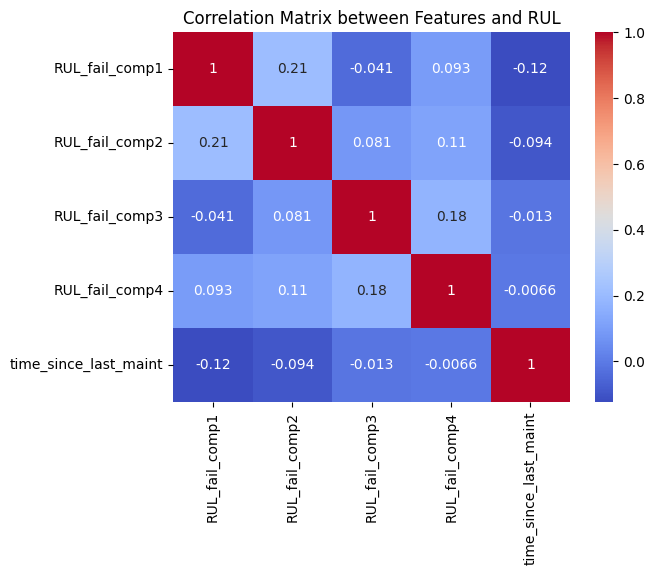

In [67]:
correlation_matrix = merged_df[['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4', 'time_since_last_maint']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix between Features and RUL")
plt.show()


- The most consistent pattern is the slight negative relationship between the time since the last maintenance and RUL for components 1 and 2. This implies that more frequent maintenance could have a positive effect on extending the life of these components.
- The RUL of certain components, such as components 3 and 4, may not be as strongly influenced by maintenance, as their correlation with time_since_last_maint is negligible.

In [69]:
# Aggregate data across all components and sensors to reduce dimensionality if needed later for model performance
merged_df['total_failure_flag'] = merged_df[['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']].max(axis=1)
merged_df['total_maint_flag'] = merged_df[['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']].max(axis=1)
merged_df['total_error_flag'] = merged_df[['error1', 'error2', 'error3', 'error4', 'error5']].max(axis=1)

merged_df['avg_rolling_mean_volt'] = merged_df[['rolling_mean_volt_fail_comp1', 'rolling_mean_volt_fail_comp2', 'rolling_mean_volt_fail_comp3', 'rolling_mean_volt_fail_comp4']].mean(axis=1)
merged_df['avg_rolling_mean_pressure'] = merged_df[['rolling_mean_pressure_fail_comp1', 'rolling_mean_pressure_fail_comp2', 'rolling_mean_pressure_fail_comp3', 'rolling_mean_pressure_fail_comp4']].mean(axis=1)
merged_df['avg_rolling_mean_rotate'] = merged_df[['rolling_mean_rotate_fail_comp1', 'rolling_mean_rotate_fail_comp2', 'rolling_mean_rotate_fail_comp3', 'rolling_mean_rotate_fail_comp4']].mean(axis=1)
merged_df['avg_rolling_mean_vibration'] = merged_df[['rolling_mean_vibration_fail_comp1', 'rolling_mean_vibration_fail_comp2', 'rolling_mean_vibration_fail_comp3', 'rolling_mean_vibration_fail_comp4']].mean(axis=1)

merged_df['avg_time_since_last_failure'] = merged_df[['time_since_last_failure_fail_comp1', 'time_since_last_failure_fail_comp2', 'time_since_last_failure_fail_comp3', 'time_since_last_failure_fail_comp4']].mean(axis=1)
merged_df['avg_RUL'] = merged_df[['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']].mean(axis=1)

merged_df.head()

,datetime_telemetry,machineID,volt,rotate,pressure,vibration,date,model,age,datetime_failure,...,total_failure_flag,total_maint_flag,total_error_flag,avg_rolling_mean_volt,avg_rolling_mean_pressure,avg_rolling_mean_rotate,avg_rolling_mean_vibration,avg_time_since_last_failure,avg_RUL,anomaly_flag
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01,1,18,0,...,0,0,0,176.217853,113.077935,418.504078,45.087686,0.0,56038.5,-1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01,1,18,0,...,0,0,0,169.548538,104.269230,410.625784,44.250829,0.0,56037.5,1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01,1,18,0,...,0,0,0,170.028993,94.592122,449.533798,40.893502,0.0,56036.5,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01,1,18,0,...,0,0,0,168.137453,98.256232,423.687682,40.950662,0.0,56035.5,1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01,1,18,0,...,0,0,0,166.031967,100.982315,426.025520,37.958632,0.0,56034.5,1


#### Feature Selection

Number of anomalies detected: 43805
Examples of anomalies detected:
    datetime_telemetry  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
24 2015-01-02 06:00:00          1  197.363125  446.943947  114.342061   
49 2015-01-03 07:00:00          1  175.213280  486.494804  104.432962   
50 2015-01-03 08:00:00          1  164.341435  568.972310   94.488533   
51 2015-01-03 09:00:00          1  171.464292  454.317959   85.246610   

    vibration        date  model  age datetime_failure  ...  \
0   45.087686  2015-01-01      1   18                0  ...   
24  29.527665  2015-01-02      1   18                0  ...   
49  47.875804  2015-01-03      1   18                0  ...   
50  49.023585  2015-01-03      1   18                0  ...   
51  47.698464  2015-01-03      1   18                0  ...   

    total_failure_flag  total_maint_flag  total_error_flag  \
0                    0                 0            

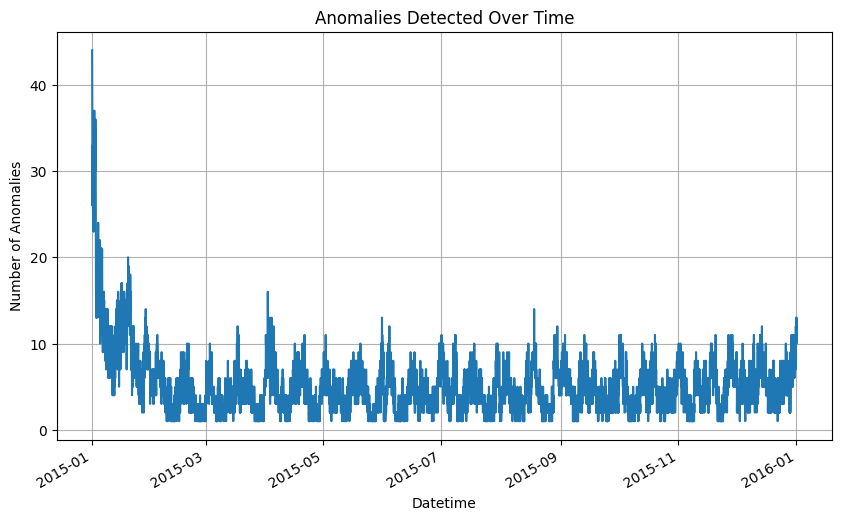

In [167]:
# Manually filtered features to target best for anomaly detection

from sklearn.ensemble import IsolationForest
columns_for_anomaly_detection = [
    'volt', 'pressure', 'vibration', 'rotate',
    'vibration_t-1', 'pressure_t-1', 'volt_t-1', 'rotate_t-1',
    'total_failure_flag', 'total_maint_flag', 'avg_rolling_mean_volt',
    'avg_rolling_mean_pressure', 'avg_rolling_mean_rotate', 
    'avg_rolling_mean_vibration', 'avg_time_since_last_failure', 
    'avg_RUL', 'error_flag', 'maint_flag', 'failure_flag', 
    'time_since_last_maint', 'pressure_x_volt', 'rotate_x_vibration', 
    'overall_maintenance_history', 'model', 'age'
]

X = merged_df[columns_for_anomaly_detection]

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
merged_df['anomaly_flag'] = iso_forest.fit_predict(X)

anomaly_count = np.sum(merged_df['anomaly_flag'] == -1)
print(f"Number of anomalies detected: {anomaly_count}")

anomalies = merged_df[merged_df['anomaly_flag'] == -1]
print("Examples of anomalies detected:")
print(anomalies.head())

anomaly_count_by_machine = merged_df[merged_df['anomaly_flag'] == -1]['machineID'].value_counts()
print("Anomaly count by machine:")
print(anomaly_count_by_machine)

merged_df['datetime_telemetry'] = pd.to_datetime(merged_df['datetime_telemetry']) 
anomalies_over_time = merged_df[merged_df['anomaly_flag'] == -1].groupby('datetime_telemetry').size()

plt.figure(figsize=(10, 6))
anomalies_over_time.plot(kind='line')
plt.title('Anomalies Detected Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Anomalies')
plt.grid(True)
plt.show()

A total of 43,805 anomalies were detected by the Isolation Forest model. This represents a significant number of outliers, which could indicate possible issues, deviations in sensor data, or extreme conditions during certain time periods.

The plot shows a noticeable spike in anomalies detected at the beginning of 2015 (January), followed by a more stable period from February to around November. There’s a slight increase in anomalies towards the end of 2015 (December).

In [168]:
# Create interactions between anomalies and failures and anomalies and maintenance
anomalies_and_failures = merged_df[(merged_df['anomaly_flag'] == -1) & (merged_df['failure_flag'] == 1)]
print(f"Number of anomalies that coincide with failures: {len(anomalies_and_failures)}")
print(anomalies_and_failures.head())

anomalies_and_maintenance = merged_df[(merged_df['anomaly_flag'] == -1) & (merged_df['maint_flag'] == 1)]
print(f"Number of anomalies that coincide with maintenance: {len(anomalies_and_maintenance)}")
print(anomalies_and_maintenance.head())

Number of anomalies that coincide with failures: 17953
     datetime_telemetry  machineID        volt      rotate    pressure  \
96  2015-01-05 06:00:00          1  179.303153  499.777962  111.833028   
97  2015-01-05 07:00:00          1  155.511452  498.398435  103.068134   
98  2015-01-05 08:00:00          1  172.439821  392.124959  108.135159   
99  2015-01-05 09:00:00          1  138.826437  451.348967  126.464580   
100 2015-01-05 10:00:00          1  177.278402  403.199389  100.858613   

     vibration        date  model  age     datetime_failure  ...  \
96   52.383097  2015-01-05      1   18  2015-01-05 06:00:00  ...   
97   33.270415  2015-01-05      1   18  2015-01-05 06:00:00  ...   
98   39.477497  2015-01-05      1   18  2015-01-05 06:00:00  ...   
99   38.257462  2015-01-05      1   18  2015-01-05 06:00:00  ...   
100  38.776021  2015-01-05      1   18  2015-01-05 06:00:00  ...   

     total_failure_flag  total_maint_flag  total_error_flag  \
96                    1     

- We can see that anomalies are strong predictors of failures, as a significant number of failures (17,953) coincide with detected anomalies. This means that anomalies in sensor readings like voltage, pressure, and vibration are likely early warning signs of impending failure, which we can leverage to build more accurate failure prediction models.

- The fact that 24,668 anomalies coincide with maintenance shows that maintenance is often triggered by anomalies. This reinforces that anomalies are not only indicative of failures but also play a crucial role in driving proactive maintenance actions, helping us prevent failures before they happen.

- The high frequency of anomalies spread across multiple hours indicates that a longer window (24 to 48 hours) is necessary to capture the build-up of anomalies and their impact on failures. We will use this to ensure our model captures the temporal dynamics of anomalies and their lead-up to failures, improving the overall robustness and accuracy of your predictions.

Mean Absolute Error for RUL_fail_comp1: 885.57
Mean Absolute Error for RUL_fail_comp2: 491.25
Mean Absolute Error for RUL_fail_comp3: 812.16
Mean Absolute Error for RUL_fail_comp4: 994.74
                               Feature  Importance
29         overall_maintenance_history    0.279461
23  time_since_last_failure_fail_comp3    0.129683
24  time_since_last_failure_fail_comp4    0.119380
21  time_since_last_failure_fail_comp1    0.091734
22  time_since_last_failure_fail_comp2    0.073958
..                                 ...         ...
9                               error1    0.000140
14                          error_flag    0.000138
12                              error4    0.000103
11                              error3    0.000090
13                              error5    0.000008

[63 rows x 2 columns]


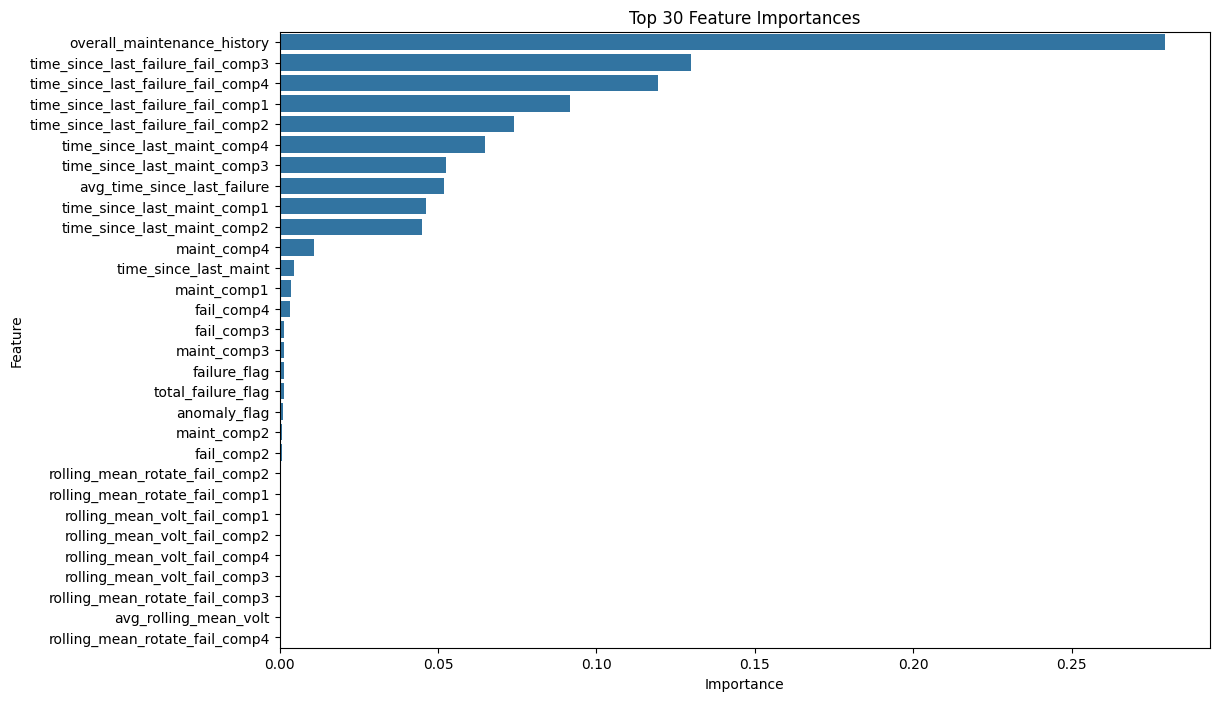

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

target_variables = ['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']
X = merged_df.drop(columns=target_variables+['machineID', 'model', 'age', 'avg_RUL'])
X = X.select_dtypes(include=[np.number])
y = merged_df[target_variables]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae_scores = {}
for i, target in enumerate(target_variables):
    mae_scores[target] = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])

for target, mae in mae_scores.items():
    print(f'Mean Absolute Error for {target}: {mae:.2f}')

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(30))
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [73]:
final_features = [
    'volt', 'pressure', 'vibration', 'rotate',
    'vibration_t-1', 'pressure_t-1', 'volt_t-1', 'rotate_t-1',
    'total_failure_flag', 'total_maint_flag', 'avg_rolling_mean_volt',
    'avg_rolling_mean_pressure', 'avg_rolling_mean_rotate', 
    'avg_rolling_mean_vibration', 'avg_time_since_last_failure', 
    'error_flag', 'anomaly_flag', 'maint_flag', 'failure_flag', 
    'time_since_last_maint', 'pressure_x_volt', 'rotate_x_vibration', 
    'overall_maintenance_history', 'model', 'age'
]

# Create a new DataFrame with only the selected features from merged_df
merged_df_final = merged_df[final_features]

In [112]:
# table_name = 'robs_processed_PdM_data'

# # Save DataFrame to the SQL database as a new table
# merged_df_final.to_sql(table_name, con=engine, if_exists='replace', index=False)

# print(f"Data saved successfully to '{table_name}' in the database.")

Data saved successfully to 'robs_processed_PdM_data' in the database.


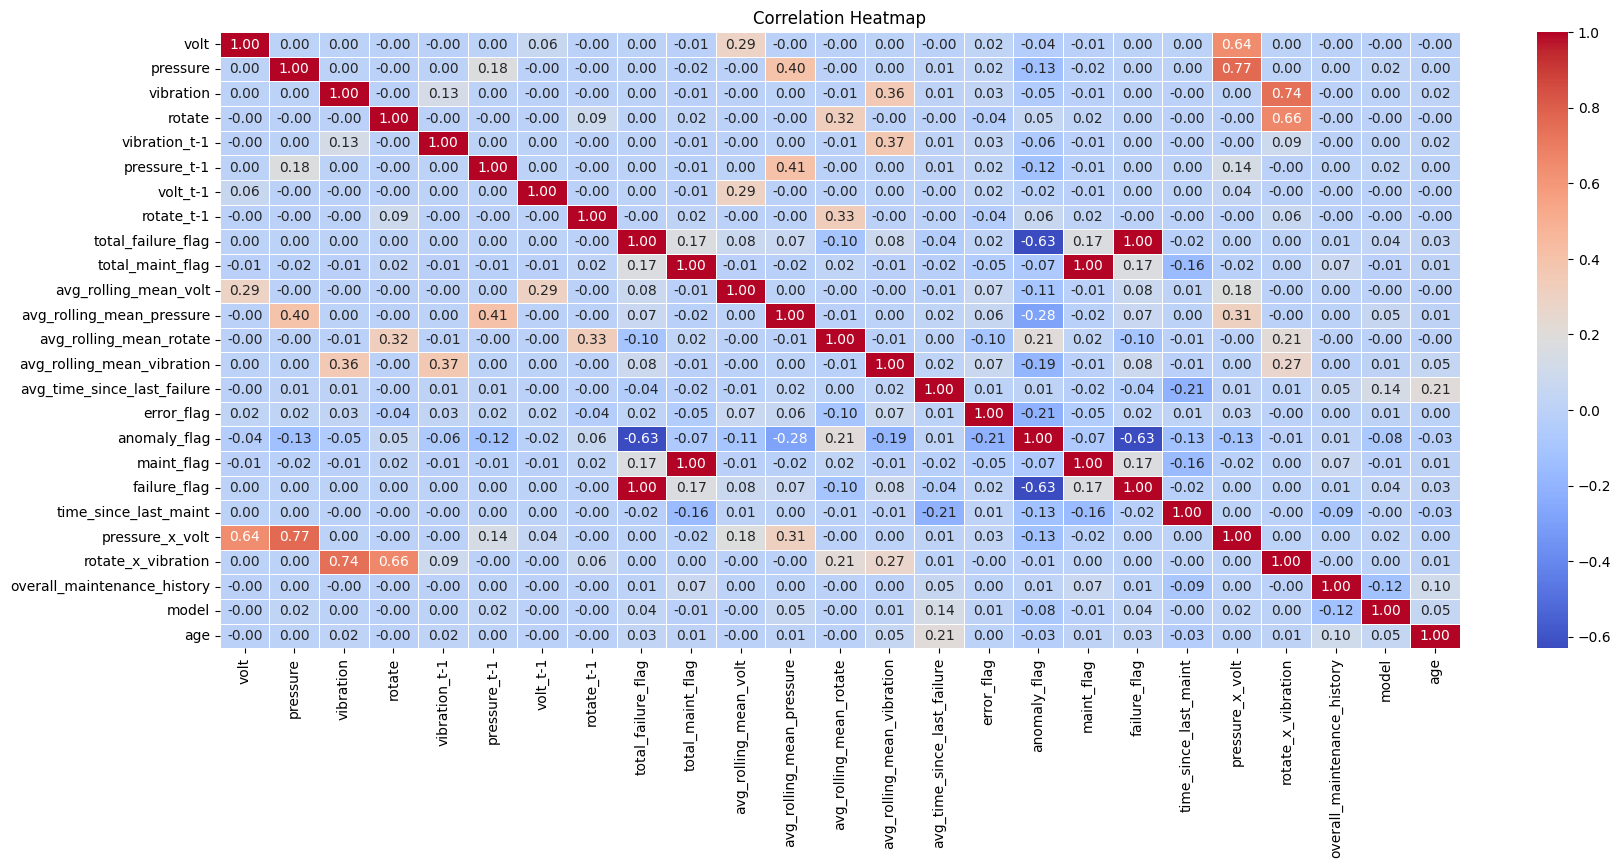

In [74]:
corr_matrix = merged_df_final.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [91]:
# Use VIF to check for multicollinearity
# # X_vif = merged_df_reduced.copy()
# # corr_matrix = X_vif.corr().abs()
# # upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
# # merged_df_reduced_2 = X_vif.drop(columns=to_drop)
# # reduced_features = merged_df_reduced_2.columns.tolist()
# # print("Reduced Features:", reduced_features)
# # len(reduced_features)

In [84]:
import os
import tensorflow as tf
from tensorflow import keras 

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model  # type: ignore
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, Conv1D, Dense, Flatten # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # type: ignore
from tcn import TCN

In [99]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

train_data = merged_df[(merged_df['datetime_telemetry'] >= '2014-06-01') &
                       (merged_df['datetime_telemetry'] <= '2015-08-31')]
val_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-09-01') &
                     (merged_df['datetime_telemetry'] <= '2015-10-31')]
test_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-11-01') &
                      (merged_df['datetime_telemetry'] <= '2015-12-31')]

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

feature_columns = [
    'volt', 'pressure', 'vibration', 'rotate',
    'vibration_t-1', 'pressure_t-1', 'volt_t-1', 'rotate_t-1',
    'total_failure_flag', 'total_maint_flag', 'avg_rolling_mean_volt',
    'avg_rolling_mean_pressure', 'avg_rolling_mean_rotate', 
    'avg_rolling_mean_vibration', 'avg_time_since_last_failure', 
    'error_flag', 'anomaly_flag', 'maint_flag', 'failure_flag', 
    'time_since_last_maint', 'pressure_x_volt', 'rotate_x_vibration', 
    'overall_maintenance_history', 'model', 'age'
]
num_features = len(feature_columns)

scaler = MinMaxScaler()
scaler.fit(train_data[feature_columns])

# X (Independent variables)
train_features_scaled = scaler.transform(train_data[feature_columns])
val_features_scaled = scaler.transform(val_data[feature_columns])
test_features_scaled = scaler.transform(test_data[feature_columns])

n_components = 12
pca = PCA(n_components=n_components)

train_features_pca = pca.fit_transform(train_features_scaled)
val_features_pca = pca.transform(val_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Explained variance ratio (PCA): {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")

# y (dependent variables)
train_regression_targets = train_data[['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']].values
val_regression_targets = val_data[['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']].values
test_regression_targets = test_data[['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']].values

target_scaler = MinMaxScaler()
target_scaler.fit(train_regression_targets)
train_regression_targets_scaled = target_scaler.transform(train_regression_targets)
val_regression_targets_scaled = target_scaler.transform(val_regression_targets)
test_regression_targets_scaled = target_scaler.transform(test_regression_targets)

print(train_features_scaled.shape)


Explained variance ratio (PCA): [0.44933306 0.11965328 0.08772218 0.08091205 0.06303407 0.04772795
 0.03982999 0.02229274 0.01716885 0.01686869 0.01291732 0.00885386]
Cumulative explained variance: [0.44933306 0.56898634 0.65670852 0.73762057 0.80065464 0.84838259
 0.88821258 0.91050532 0.92767417 0.94454287 0.95746018 0.96631404]
(580300, 25)


In [101]:
import numpy as np

def create_sequences(features, regression_targets, sequence_length=24):
    """
    Create sequences of features and corresponding regression targets for time series prediction.

    Parameters:
    - features: numpy array of shape (num_samples, num_features), input features.
    - regression_targets: numpy array of shape (num_samples, num_targets), target for regression (e.g., RUL).
    - sequence_length: int, the length of the sequences to create.

    Returns:
    - X: numpy array of shape (num_sequences, sequence_length, num_features), input sequences.
    - y: numpy array of shape (num_sequences, num_targets), regression targets for the last time step of each sequence.
    """
    X = np.array([features[i:i + sequence_length] for i in range(len(features) - sequence_length)])
    y = np.array([regression_targets[i + sequence_length] for i in range(len(features) - sequence_length)])
    return X, y

sequence_length = 24  

X_train, y_train = create_sequences(train_features_pca, train_regression_targets_scaled, sequence_length)
X_val, y_val = create_sequences(val_features_pca, val_regression_targets_scaled, sequence_length)
X_test, y_test = create_sequences(test_features_pca, test_regression_targets_scaled, sequence_length)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


Training Set - X shape: (580276, 24, 12), y shape: (580276, 4)
Validation Set - X shape: (144076, 24, 12), y shape: (144076, 4)
Test Set - X shape: (144076, 24, 12), y shape: (144076, 4)
X_train shape: (580276, 24, 12)
X_val shape: (144076, 24, 12)
X_test shape: (144076, 24, 12)


In [103]:
import tcn
from tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import HeNormal, l2

input_shape = (sequence_length, 12) #from PCA reduction
inputs = Input(shape=input_shape)

x = TCN(nb_filters=128, kernel_size=3, dilations=[1, 2, 4, 8, 16],
        nb_stacks=3, padding='causal', kernel_initializer=HeNormal())(inputs)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
output_reg_comp1 = Dense(1, activation='linear', name='regression_output_comp1')(x)
output_reg_comp2 = Dense(1, activation='linear', name='regression_output_comp2')(x)
output_reg_comp3 = Dense(1, activation='linear', name='regression_output_comp3')(x)
output_reg_comp4 = Dense(1, activation='linear', name='regression_output_comp4')(x)

model = Model(inputs=inputs, outputs=[output_reg_comp1, output_reg_comp2, output_reg_comp3, output_reg_comp4])

model.compile(optimizer='adam',
              loss={
                  'regression_output_comp1': 'mean_absolute_error',
                  'regression_output_comp2': 'mean_absolute_error',
                  'regression_output_comp3': 'mean_absolute_error',
                  'regression_output_comp4': 'mean_absolute_error'
              },
              metrics={
                  'regression_output_comp1': ['mean_absolute_error'],
                  'regression_output_comp2': ['mean_absolute_error'],
                  'regression_output_comp3': ['mean_absolute_error'],
                  'regression_output_comp4': ['mean_absolute_error']
              })

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn_1 (TCN)         │ (None, 128)       │  1,435,520 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ tcn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output_… │ (None, 1)         │        129 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output_… │ (None, 1)         │        129 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output_… │ (None, 1)         │        129 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output_… │ (None, 1)         │        129 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,452,548 (5.54 MB)

 Trainable params: 1,452,548 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005)

y_train_dict = {f'regression_output_comp{i+1}': y_train[:, i] for i in range(4)}
y_val_dict = {f'regression_output_comp{i+1}': y_val[:, i] for i in range(4)}

history = model.fit(
    X_train,
    y_train_dict,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val_dict),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
18134/18134 ━━━━━━━━━━━━━━━━━━━━ 1558s 85ms/step - loss: 11.9915 - regression_output_comp1_loss: 3.5473 - regression_output_comp1_mean_absolute_error: 3.5473 - regression_output_comp2_loss: 2.3066 - regression_output_comp2_mean_absolute_error: 2.3066 - regression_output_comp3_loss: 1.7267 - regression_output_comp3_mean_absolute_error: 1.7267 - regression_output_comp4_loss: 4.4109 - regression_output_comp4_mean_absolute_error: 4.4109 - val_loss: 1.4665 - val_regression_output_comp1_loss: 0.5754 - val_regression_output_comp1_mean_absolute_error: 0.5754 - val_regression_output_comp2_loss: 0.4358 - val_regression_output_comp2_mean_absolute_error: 0.4359 - val_regression_output_comp3_loss: 0.1310 - val_regression_output_comp3_mean_absolute_error: 0.1310 - val_regression_output_comp4_loss: 0.3242 - val_regression_output_comp4_mean_absolute_error: 0.3242 - learning_rate: 0.0010
Epoch 2/5
18134/18134 ━━━━━━━━━━━━━━━━━━━━ 1528s 84ms/step - loss: 0.4884 - regression_output_comp1_loss: 

Key Insights:
- The model shows consistent improvement across both the training and validation sets.
- The validation loss and MAE metrics are steadily decreasing, indicating that the model is generalizing well to the validation data and not overfitting.

In [106]:
import tensorflow as tf
model_path = r'C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 9 - Project\Project\ds23_projektkurs\predictive-maintenance\models\Trained models'
model_save_path = os.path.join(model_path, 'tcn_multitask_model_v1.keras')
model.save(model_save_path)

In [135]:
predictions = model.predict(X_test)

4503/4503 ━━━━━━━━━━━━━━━━━━━━ 118s 26ms/step


In [138]:
predictions

[array([[0.0169469 ],
        [0.0169469 ],
        [0.0169469 ],
        ...,
        [0.007061  ],
        [0.00996776],
        [0.00733509]], dtype=float32),
 array([[0.00903047],
        [0.00903047],
        [0.00903047],
        ...,
        [0.00475519],
        [0.00527331],
        [0.0047769 ]], dtype=float32),
 array([[0.98417485],
        [0.98417485],
        [0.98417485],
        ...,
        [0.98350894],
        [0.9871708 ],
        [0.9837322 ]], dtype=float32),
 array([[0.00496297],
        [0.00496297],
        [0.00496297],
        ...,
        [0.9797527 ],
        [0.9827355 ],
        [0.97979724]], dtype=float32)]

In [140]:
predictions_array = np.hstack(predictions)  # Stack predictions into a single array
predictions_array

array([[0.0169469 , 0.00903047, 0.98417485, 0.00496297],
       [0.0169469 , 0.00903047, 0.98417485, 0.00496297],
       [0.0169469 , 0.00903047, 0.98417485, 0.00496297],
       ...,
       [0.007061  , 0.00475519, 0.98350894, 0.9797527 ],
       [0.00996776, 0.00527331, 0.9871708 , 0.9827355 ],
       [0.00733509, 0.0047769 , 0.9837322 , 0.97979724]], dtype=float32)

In [142]:
inv_predictions = target_scaler.inverse_transform(predictions_array)
inv_predictions

array([[  3726.7256,   1985.8553, 216425.95  ,   1091.386 ],
       [  3726.7256,   1985.8553, 216425.95  ,   1091.386 ],
       [  3726.7256,   1985.8553, 216425.95  ,   1091.386 ],
       ...,
       [  1552.7568,   1045.695 , 216279.52  , 215453.5   ],
       [  2191.9712,   1159.6329, 217084.78  , 216109.44  ],
       [  1613.0314,   1050.468 , 216328.62  , 215463.3   ]],
      dtype=float32)

In [150]:
unscaled_y_test = target_scaler.inverse_transform(y_test)

# MAE for each component unscaled
mae_per_component = mean_absolute_error(unscaled_y_test, inv_predictions, multioutput='raw_values')
for i, mae in enumerate(mae_per_component, 1):
    print(f"MAE for Component {i}: {mae}")

MAE for Component 1: 113913.88364677691
MAE for Component 2: 148276.51537308065
MAE for Component 3: 49662.66223515323
MAE for Component 4: 75139.46925789237


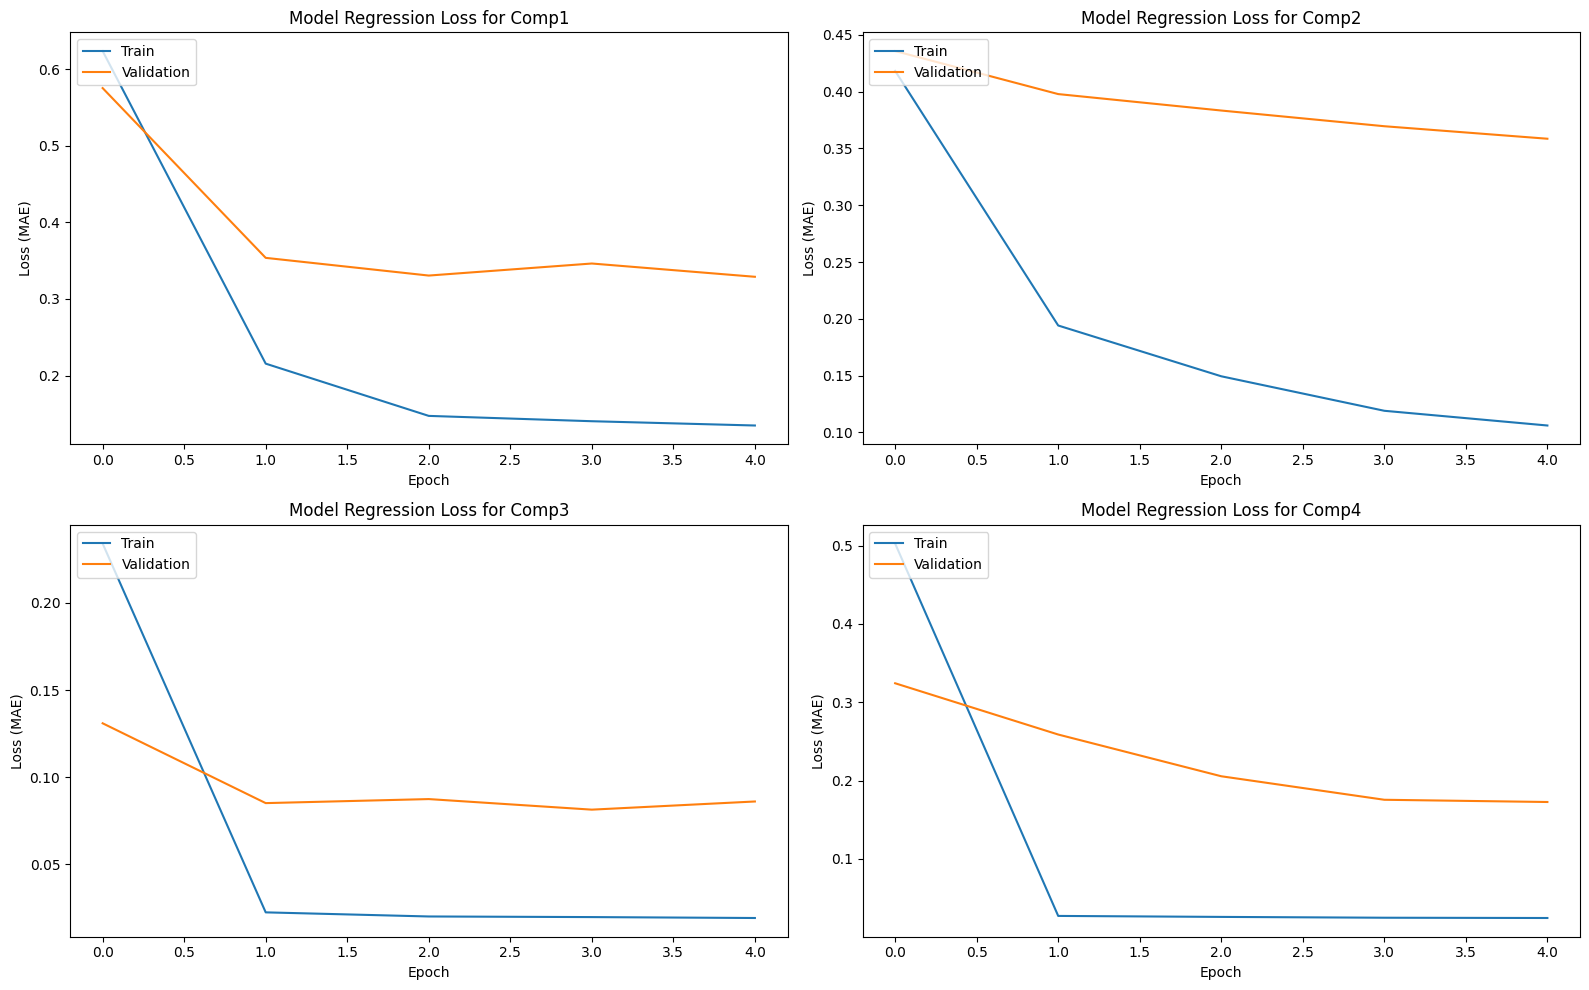

In [111]:
plt.figure(figsize=(16, 10))

# Plot for Regression Loss for Component 1
plt.subplot(2, 2, 1)
plt.plot(history.history['regression_output_comp1_loss'], label='Train')
plt.plot(history.history['val_regression_output_comp1_loss'], label='Validation')
plt.title('Model Regression Loss for Comp1')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot for Regression Loss for Component 2
plt.subplot(2, 2, 2)
plt.plot(history.history['regression_output_comp2_loss'], label='Train')
plt.plot(history.history['val_regression_output_comp2_loss'], label='Validation')
plt.title('Model Regression Loss for Comp2')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot for Regression Loss for Component 3
plt.subplot(2, 2, 3)
plt.plot(history.history['regression_output_comp3_loss'], label='Train')
plt.plot(history.history['val_regression_output_comp3_loss'], label='Validation')
plt.title('Model Regression Loss for Comp3')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot for Regression Loss for Component 4
plt.subplot(2, 2, 4)
plt.plot(history.history['regression_output_comp4_loss'], label='Train')
plt.plot(history.history['val_regression_output_comp4_loss'], label='Validation')
plt.title('Model Regression Loss for Comp4')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


-The training losses decrease rapidly across all components.
- The validation losses start higher and decrease less rapidly, which suggests some overfitting, particularly for Components 1 and 2.
- If we had time, we would look closer to figure out if there are particular components or patterns in the data that are causing issues. We could also try running more epochs, reducing model complexity and adding L2 regularization. 

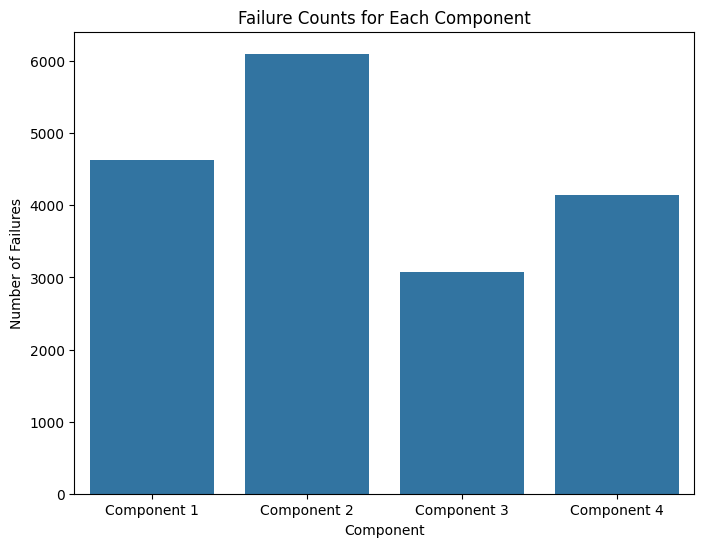

In [145]:
# Check class imbalance
failure_counts = {
    'Component 1': merged_df['fail_comp1'].sum(),
    'Component 2': merged_df['fail_comp2'].sum(),
    'Component 3': merged_df['fail_comp3'].sum(),
    'Component 4': merged_df['fail_comp4'].sum()
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(failure_counts.keys()), y=list(failure_counts.values()))
plt.title('Failure Counts for Each Component')
plt.ylabel('Number of Failures')
plt.xlabel('Component')
plt.show()


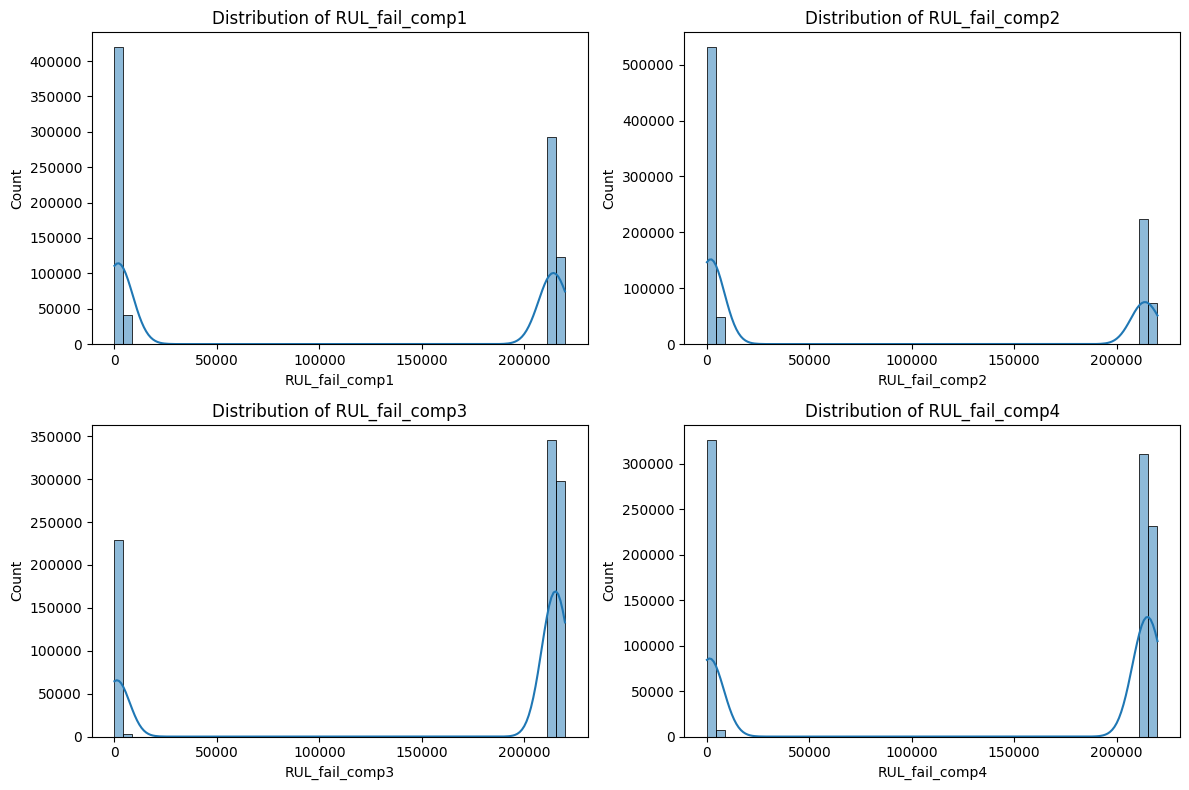

In [148]:
components = ['RUL_fail_comp1', 'RUL_fail_comp2', 'RUL_fail_comp3', 'RUL_fail_comp4']

# Distribution of RUL values for each component
plt.figure(figsize=(12, 8))
for i, comp in enumerate(components):
    plt.subplot(2, 2, i + 1)
    sns.histplot(merged_df[comp], bins=50, kde=True)
    plt.title(f'Distribution of {comp}')
plt.tight_layout()
plt.show()


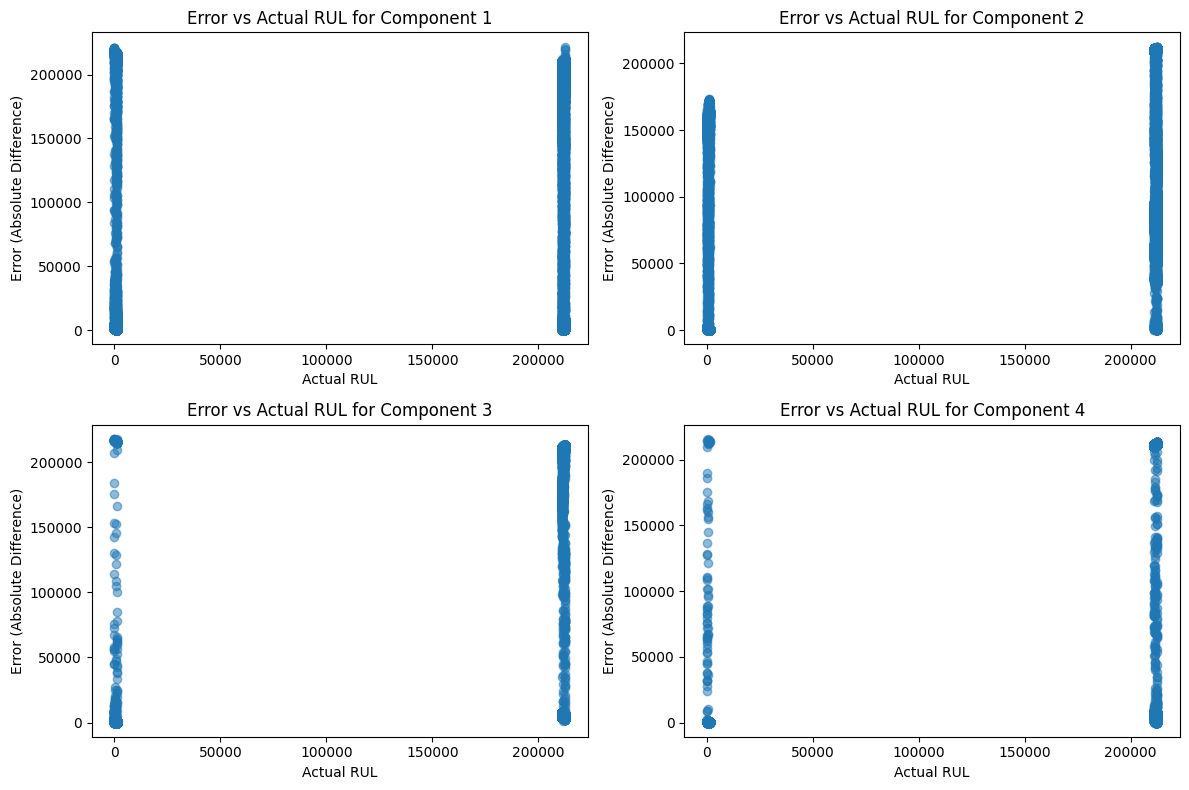

In [151]:
# Actual vs predicted RULs for each component
error_analysis_df = pd.DataFrame({
    'Actual_RUL_comp1': unscaled_y_test[:, 0],
    'Predicted_RUL_comp1': inv_predictions[:, 0],
    'Actual_RUL_comp2': unscaled_y_test[:, 1],
    'Predicted_RUL_comp2': inv_predictions[:, 1],
    'Actual_RUL_comp3': unscaled_y_test[:, 2],
    'Predicted_RUL_comp3': inv_predictions[:, 2],
    'Actual_RUL_comp4': unscaled_y_test[:, 3],
    'Predicted_RUL_comp4': inv_predictions[:, 3],
})

error_analysis_df['Error_comp1'] = abs(error_analysis_df['Actual_RUL_comp1'] - error_analysis_df['Predicted_RUL_comp1'])
error_analysis_df['Error_comp2'] = abs(error_analysis_df['Actual_RUL_comp2'] - error_analysis_df['Predicted_RUL_comp2'])
error_analysis_df['Error_comp3'] = abs(error_analysis_df['Actual_RUL_comp3'] - error_analysis_df['Predicted_RUL_comp3'])
error_analysis_df['Error_comp4'] = abs(error_analysis_df['Actual_RUL_comp4'] - error_analysis_df['Predicted_RUL_comp4'])

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(error_analysis_df[f'Actual_RUL_comp{i+1}'], error_analysis_df[f'Error_comp{i+1}'], alpha=0.5)
    plt.title(f'Error vs Actual RUL for Component {i+1}')
    plt.xlabel('Actual RUL')
    plt.ylabel('Error (Absolute Difference)')
plt.tight_layout()
plt.show()

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('mssql+pyodbc://MSI/predictive_maintenance_db?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')
table_name = 'robs_merged_PdM_data'
merged_df.to_sql(name=table_name, con=engine, if_exists='replace', index=False)

print(f"Table '{table_name}' has been successfully saved to the database.")